In [1]:
import os
import random
import sys

import time

import yaml

from pathlib import Path

from copy import deepcopy

import numpy as np
import math

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from torchvision.io import read_image, ImageReadMode
import torchvision

import albumentations as A
from albumentations.pytorch import ToTensorV2

from pytorch_model_summary import summary

from fLossFunctions import v8DetectionLoss
from fValidation import v8DetectionValidator

from collections import defaultdict
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt

import pandas as pd

In [2]:
params = {
    "data_dir": '/media/pipeh/Data/Datasets/MinneApple', #"/media/pipeh/Data/Datasets/MinneApple", # "D:/Datasets/MinneApple",
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "save_pth": "checkpoint/minne_apple",
    "batch_size": 32,
    "epochs": 200,
    "img_size": 320,
    "mixup_thr": 1.,
    "reg_max": 4,
    "version": 'newv10',
}

## Build datasets

In [3]:
class DetectionDataset(Dataset):
    """
    SuperClass with pytorch Dataset methods to manage an object detection dataset, loading its images
    with its labels and applying the basic data augmentation pipelines.
    
    Args:
        args (dict): script hyper parameters and arguments.
        partition (string): Dataset mode for train or test partition and data augmentations.
        transform (Albumentation Compose): Data augmentation pipeline for images in train or test.
    
    Attributes:
        mode (String): dataset mode: train or test.
        subset_images (string): image dataset subset folder name.
        subset_labels (string): labels dataset subset folder name.
        mosaic (bool): flag if use mosaic images.
        transform (Albumentation Compose): data augmentation pipeline.
        img_size (int): image size w,h to resize images.
        file_ids (list): names of the files of the images.
        
    Methods:
        __len__(self): return the lenght of dataset subset.
        __getitem__(self, idx): return a batch composed by images, its bboxes and classes labels for each box, depending if
                                mixup augmentation is true.
        load_image(self, idx): load and return a single sample composed by an image, its bboxes and classes labels for each box.
    """
    
    def __init__(self, args, partition=None, transform=None):
        super(DetectionDataset, self).__init__()
        self.params = args
        self.mode = partition
        self.img_size = args["img_size"]
        self.transform = transform
        
        self.subset_images = self.subset_labels = ''
        if self.mode == 'train':
            self.subset_images += 'train'
            self.subset_labels += 'train'                
        else:
            self.subset_images += 'val'
            self.subset_labels += 'val'
        
        self.file_ids = os.listdir(f'{self.params["data_dir"]}/labels/{self.subset_labels}')
    
    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, idx):
        image, bboxes, labels = self.load_image(idx)
        return image, bboxes, labels
        
    def load_image(self, idx):
        file_name = self.file_ids[idx]
        bboxes = []
        labels = []
        image = read_image(f'{self.params["data_dir"]}/images/{self.subset_images}/{file_name[:-4]}.png', ImageReadMode.RGB)
        with open(f'{self.params["data_dir"]}/labels/{self.subset_labels}/{file_name}', 'r') as f:
            for line in f.readlines():
                line_data = list(map(float, line.strip().split()))
                labels.append(int(0.))
                bboxes.append(line_data[1:])
        transformed = self.transform(image=np.array(image.permute(1,2,0), np.float32) / 255., 
                                     bboxes=bboxes, 
                                     class_labels=labels)
        image = transformed['image']
        bboxes = transformed['bboxes']
        labels = transformed['class_labels']
        bboxes = torch.tensor(bboxes)
        labels = torch.tensor(labels).unsqueeze(dim=-1)
        return image, bboxes, labels

In [4]:
class ProcessBatch(object):
    """
    Preprocessing class that takes a list of tuples of images, bboxes and labels and arranges them as a batch of
    given lenght, and applies MixUp augmentation if a random probability surprass a threshold.
    
    Attributes:
        n_max_boxes (int): maxium number of zeros batch padding.
        thr (float): threshold to apply mixup augmentation
        
    Methods_
        __call__(self, batch): return a batched set of images, bounding boxes and labels.
        pad_batch(self, batch): return a batched set of images, bounding boxes and labels.
        mixup_batch(self, batch): return a batched set of images, bounding boxes and labels with MixUp augmentation
                                with its same batch but randomly shuffled.
                                
    """
    def __init__(self, thr=0.5):
        self.n_max_boxes = 128
        self.n_max_boxes_mixup = 256
        self.thr = thr
        
    def __call__(self, batch):
        if random.random() < self.thr:
            images, bboxes, labels = self.mixup_batch(batch)
            return images, bboxes, labels
        else:
            images, bboxes, labels = self.normal_batch(batch)
            return images, bboxes, labels

    def normal_batch(self, batch):
        img_tuple, bboxes_tuple, labels_tuple = zip(*batch)
        images  = torch.stack(list(img_tuple), dim=0)
        bboxes = torch.tensor([])
        labels = torch.tensor([])
        for box,label in zip(bboxes_tuple, labels_tuple):
            box, label = self.pad_batch(box, label, self.n_max_boxes)
            bboxes = torch.cat([bboxes, box.unsqueeze(0)], dim=0)
            labels = torch.cat([labels, label.unsqueeze(0)], dim=0)
        return images, bboxes, labels
    
    def mixup_batch(self, batch):
        img_x, bboxes_x, labels_x = zip(*batch)
        batch = list(batch)
        batch.append(batch.pop(0))
        img_y, bboxes_y, labels_y = zip(*batch)
        img_x  = torch.stack(list(img_x), dim=0)
        img_y  = torch.stack(list(img_y), dim=0)
        alpha = (0.6 - 0.4) * torch.rand(img_x.size(0), 1, 1, 1) + 0.4
        img = alpha * img_x + (1 - alpha) * img_y
        bboxes = torch.tensor([])
        labels = torch.tensor([])
        for boxA, boxB, labelA, labelB in zip(bboxes_x, bboxes_y, labels_x, labels_y):
            box = torch.cat([boxA, boxB], dim=0)
            label = torch.cat([labelA, labelB], dim=0)
            box, label = self.pad_batch(box, label, self.n_max_boxes_mixup)
            bboxes = torch.cat([bboxes, box.unsqueeze(0)], dim=0)
            labels = torch.cat([labels, label.unsqueeze(0)], dim=0)
        return img, bboxes, labels
    
    def pad_batch(self, bboxes, labels, nmax):
        bs = bboxes.shape[0]
        n = nmax - bs
        if n>0:
            bboxes = torch.cat([bboxes, torch.zeros(n,4)])
            labels = torch.cat([labels, torch.zeros(n,1)])
        elif n<0:
            bboxes = bboxes[:nmax]
            labels = labels[:nmax]
        return bboxes, labels

In [5]:
def build_dataloader(args, transforms):
    """
    Function to build dataset given a directory path and a set of transforms pipeline.
    
    Args:
        args (dict): script hyper parameters and arguments.
        transforms (dict): Different data augmentation pipelines for images in train or test.
        
    Return:
        dataset (Dataset): the builded dataset of a given subset.
        dataloader (Dataloader): the dataloader method for the dataset.
    """
    dataset = dict()
    dataloader = dict()
    transform = transforms
    for x in ['train', 'val']:
        dataset[x] = DetectionDataset(
            args,
            partition=x,
            transform=transform[x]
        )
        if x == 'train':
            preprocces_batch = ProcessBatch(thr=args["mixup_thr"])
        else:
            preprocces_batch = ProcessBatch(thr=0.)            
        dataloader[x] = DataLoader(
            dataset[x],
            batch_size=args["batch_size"],
            collate_fn=preprocces_batch,
            num_workers=4,
            shuffle=True,
        )
    return dataset, dataloader

In [6]:
data_transforms = {
    'train': A.Compose([
        #A.LongestMaxSize (max_size=params['img_size']),
        #A.PadIfNeeded(params['img_size'], params['img_size'], border_mode=0, value=(0.5, 0.5, 0.5)),
        A.SmallestMaxSize (max_size=params['img_size']),
        A.RandomCrop (height=params['img_size'], width=params['img_size']),
        #A.Resize (params['img_size'], params['img_size']),
        A.ShiftScaleRotate (shift_limit=0., scale_limit=[0., 0.9], rotate_limit=0., p=1.0),
        A.ColorJitter (p=1.0),
        A.HorizontalFlip (p=0.5),
        ToTensorV2 (),
    ], bbox_params=A.BboxParams(format='coco',
                                min_area=0.0,
                                min_visibility=0.0,
                                label_fields=['class_labels'])),
    'val': A.Compose([
        A.SmallestMaxSize (max_size=params['img_size']),
        A.PadIfNeeded(params['img_size'], params['img_size'], border_mode=0, value=(0.5, 0.5, 0.5)),
        #A.Resize (params['img_size'], params['img_size']),
        ToTensorV2 (),
    ], bbox_params=A.BboxParams(format='coco',
                                label_fields=['class_labels'])),
}

In [7]:
dataset, dataloader = build_dataloader(params, data_transforms)
dataset_sizes = {x: len(dataset[x]) for x in ['train','val']}
print(f"dataset_sizes {dataset_sizes}")

classes = {0: 'fruit'}

nclasses = len(classes)
print(f'number of classes: {nclasses} \nclasses: {[v for x,v in classes.items()]}')

dataset_sizes {'train': 670, 'val': 331}
number of classes: 1 
classes: ['fruit']


In [8]:
def visualize_coco_bbox(img, bbox, class_name, thickness=2):
    """ Draw a single bounding box on the image. """
    BOX_COLOR = (255, 0, 0) # Red
    TEXT_COLOR = (255, 255, 255) # White

    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=TEXT_COLOR, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img

In [9]:
def visualize_dataset(dataloader, category_id_to_name):
    """
    Shows a single image with its corresponding labels for the given dataloader
    dataset method.
    
    Args:
        dataloader (Dataloader): dataloader of the dataset subset to extract sample.
        category_id_to_name (dict): name of each classes corresponding to the label index.
    """
    image, bboxes, category_ids = next(iter(dataloader))
    image = image[0].unsqueeze(0)
    bboxes = bboxes[0].unsqueeze(0)
    category_ids = category_ids[0].unsqueeze(0)
    mask_gt = bboxes.sum(2, keepdim=True).gt_(0)
    bs = bboxes.shape[0]
    bboxes = bboxes[mask_gt.expand(-1, -1, 4).bool()].view(bs, -1, 4)
    category_ids = category_ids[mask_gt.bool()].view(bs, -1, 1)
    img = image[0].permute(1,2,0).numpy().copy()
    for bbox, category_id in zip(bboxes.numpy()[0], category_ids.numpy()[0]):
        class_name = category_id_to_name[category_id[0]]
        img = visualize_coco_bbox(img, bbox, class_name)
    plt.figure()
    plt.axis('off')
    plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


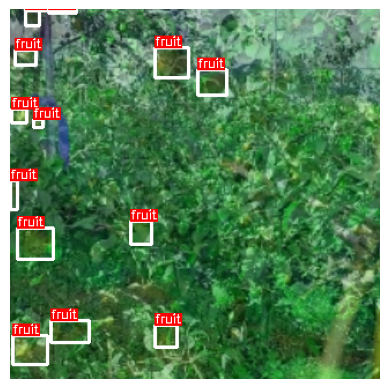

In [10]:
visualize_dataset(dataloader['train'], classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


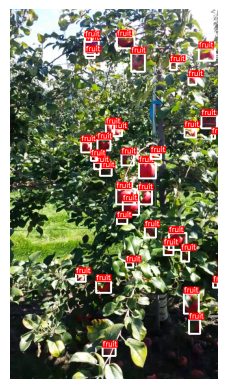

In [11]:
visualize_dataset(dataloader['val'], classes)

## Build detection model

In [12]:
class ConvModule(nn.Module):
    """
    Convolutional block composed of conv->batchnorm->relu. 
    """
    def __init__(self, cin=1, cout=1, k=1, s=1, p=0, device='cpu'):
        super(ConvModule, self).__init__()
        self.conv = nn.Conv2d(cin, cout, (k, k), stride=s, padding=p, bias=False).to(device)
        self.bn = nn.BatchNorm2d(cout, eps=0.001, momentum=0.03, affine=True, track_running_stats=True).to(device)
        self.silu = nn.SiLU(inplace=True).to(device)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.silu(x)
        return x

In [13]:
class Bottleneck(nn.Module):
    """ 
    Bottleneck block componsed of conv->conv->residual connection. 
    """
    def __init__(self, c=1, shortcut=False, device='cpu'):
        super(Bottleneck, self).__init__()
        self.conv1 = ConvModule(cin=c, cout=c//2, k=3, s=1, p=1, device=device)
        self.conv2 = ConvModule(cin=c//2, cout=c, k=3, s=1, p=1, device=device)
        self.shortcut = shortcut
        
    def forward(self, x):
        xin = x
        x = self.conv1(x)
        x = self.conv2(x)
        if self.shortcut==True:
            x = xin + x
            return x
        return x

In [14]:
class C2f(nn.Module):
    """ 
    C2f module (cross-stage partial bottleneck with two convolutions) which combines 
    high-level features with contextual information to improve detection accuracy. 
    """
    def __init__(self, cin=1, cout=1, depth=1, device='cpu'):
        super(C2f, self).__init__()
        self.cout = cout
        self.depth = depth
        self.convmodule1 = ConvModule(cin=cin, cout=cout, k=1, s=1, p=0, device=device)
        bottleneck = []
        for _ in range(depth):
            bottleneck.append(Bottleneck(c=self.cout//2, shortcut=True, device=device))
        self.bottleneck = nn.Sequential(*bottleneck)
        cin = cout//2 * (depth+2)
        self.convmodule2 = ConvModule(cin=cin, cout=cout, k=1, s=1, p=0, device=device)
        
    def forward(self, x):
        x1 = self.convmodule1(x)
        x1_1, x1_2 = torch.split(x1, self.cout//2, dim=1)
        x3 = torch.cat([x1_1, x1_2],dim=1)
        for mod in self.bottleneck:
            x2 = mod(x1_2)
            x3 = torch.cat([x3, x2], dim=1)
            x1_2 = x2
        x = self.convmodule2(x3)
        return x

In [15]:
class SPPF(nn.Module):
    """ 
    Spatial pyramid pooling fast module (SPPF) layer accelerates computation 
    by pooling features into a fixed-size map. 
    """
    def __init__(self, c=1, device='cpu'):
        super(SPPF, self).__init__()
        self.conv1 = ConvModule(cin=c, cout=c, k=1, s=1, p=0, device=device)
        self.mp1 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False).to(device)
        self.mp2 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False).to(device)
        self.mp3 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False).to(device)
        self.conv2 = ConvModule(cin=c*4, cout=c, k=1, s=1, p=0, device=device)

    def forward(self, x):
        x = self.conv1(x)
        x1 = self.mp1(x)
        x2 = self.mp2(x1)
        x3 = self.mp3(x2)
        x = torch.cat([x, x1, x2, x3], dim=1)
        x = self.conv2(x)
        return x

In [16]:
class DetectionHead(nn.Module):
    """
    Detection head module, which is decoupled to regression, classification, 
    and depth central pixel estimation tasks independently.
    """
    def __init__(self, c=1, reg_max=1, nclass=1, device='cpu'):
        super(DetectionHead, self).__init__()
        d = max(c, reg_max*4)
        self.bboxconv1 = ConvModule(cin=c, cout=d, k=3, s=1, p=1, device=device)
        self.bboxconv2 = ConvModule(cin=d, cout=d, k=3, s=1, p=1, device=device)
        self.bboxconv3 = nn.Conv2d(d, 4*reg_max, (1, 1), stride=1, padding=0, bias=False).to(device)
        self.clsconv1 = ConvModule(cin=c, cout=d, k=3, s=1, p=1, device=device)
        self.clsconv2 = ConvModule(cin=d, cout=d, k=3, s=1, p=1, device=device)
        self.clsconv3 = nn.Conv2d(d, nclass, (1, 1), stride=1, padding=0, bias=False).to(device)
        self.dptconv1 = ConvModule(cin=c, cout=d, k=3, s=1, p=1, device=device)
        self.dptconv2 = ConvModule(cin=d, cout=d, k=3, s=1, p=1, device=device)
        self.dptconv3 = nn.Conv2d(d, 1, (1, 1), stride=1, padding=0, bias=False).to(device)
      
    def forward(self, x):
        # bbox branch
        xbbox = self.bboxconv1(x)
        xbbox = self.bboxconv2(xbbox)
        xbbox = self.bboxconv3(xbbox)
        # cls branch
        xcls = self.clsconv1(x)
        xcls = self.clsconv2(xcls)
        xcls = self.clsconv3(xcls)
        # depth branch
        xdpt = self.dptconv1(x)
        xdpt = self.dptconv2(xdpt)
        xdpt = self.dptconv3(xdpt)
        
        feats = torch.cat([xbbox, xcls, xdpt], dim=1) 
        return feats

In [17]:
class DFL(nn.Module):
    """
    Integral module of Distribution Focal Loss (DFL).
    Proposed in Generalized Focal Loss https://ieeexplore.ieee.org/document/9792391
    """
    def __init__(self, c1=16, device='cpu'):
        """Initialize a convolutional layer with a given number of input channels."""
        super(DFL, self).__init__()
        self.conv = nn.Conv2d(c1, 1, 1, bias=False).requires_grad_(False).to(device)
        x = torch.arange(c1, dtype=torch.float)
        self.conv.weight.data[:] = nn.Parameter(x.view(1, c1, 1, 1))
        self.c1 = c1

    def forward(self, x):
        """Applies a transformer layer on input tensor 'x' and returns a tensor."""
        b, c, a = x.shape  # batch, channels, anchors
        return self.conv(x.view(b, 4, self.c1, a).transpose(2, 1).softmax(1)).view(b, 4, a)

In [18]:
class Inference(nn.Module):
    def __init__(self, nclasses=1, stride=None, reg_max=1, device='cpu'):
        super(Inference, self).__init__()
        self.stride = stride
        self.nc = nclasses
        self.reg_max = reg_max
        self.no = self.reg_max*4 + nclasses + 1
        self.dfl = DFL(self.reg_max, device=device) #if self.reg_max > 1 else nn.Identity()
        
    def forward(self, feats):
        # Extract predictions from each head at different strides
        pred_distri, pred_scores, pred_depth = torch.cat([xi.view(feats[0].shape[0], self.no, -1) for xi in feats], 2).split((self.reg_max*4, self.nc, 1), 1)
        pred_scores = pred_scores.permute(0, 1, 2).contiguous() # (b, nc, h*w)
        pred_distri = pred_distri.permute(0, 1, 2).contiguous() # (b, 4*reg_max, h*w)
        pred_depth = pred_depth.permute(0, 1, 2).contiguous() # (b, 1, h*w)
        # Get anchor point centers from output grids and its corresponding stride
        anchors, strides = (x.transpose(0, 1) for x in self.make_anchors(feats, self.stride, 0.5))
        # Decode reg_max*4 prediction to cxywh bounding box prediction
        dbox = self.dist2bbox(self.dfl(pred_distri), anchors.unsqueeze(0), xywh=True, dim=1).clamp_(0.) * strides
        y = torch.cat((dbox, pred_scores.sigmoid(), pred_depth.sigmoid()), 1) # (bs, 4 + nclasses + depth, h*w)
        return y
    
    def dist2bbox(self, distance, anchor_points, xywh=True, dim=-1):
        """Transform distance(ltrb) to box(xywh or xyxy).
                width and height of bounding box are in range [0, 2*(self.reg_max-1)] owing to (x2y2-x1y1=rb+lt) 
        """
        lt, rb = distance.chunk(2, dim) # lt and rb is in range[0, self.reg_max-1] 
        x1y1 = anchor_points - lt
        x2y2 = anchor_points + rb
        if xywh:
            c_xy = (x1y1 + x2y2) / 2
            wh = x2y2 - x1y1
            return torch.cat((c_xy, wh), dim)  # xywh bbox
        return torch.cat((x1y1, x2y2), dim)  # xyxy bbox

    def make_anchors(self, feats, strides, grid_cell_offset=0.5):
        """Generate anchors from features."""
        anchor_points, stride_tensor = [], []
        assert feats is not None
        dtype, device = feats[0].dtype, feats[0].device
        for i, stride in enumerate(strides):
            _, _, h, w = feats[i].shape
            sx = torch.arange(end=w, device=device, dtype=dtype) + grid_cell_offset  # shift x
            sy = torch.arange(end=h, device=device, dtype=dtype) + grid_cell_offset  # shift y
            sy, sx = torch.meshgrid(sy, sx, indexing='ij')
            anchor_points.append(torch.stack((sx, sy), -1).view(-1, 2))
            stride_tensor.append(torch.full((h * w, 1), stride, dtype=dtype, device=device))
        return torch.cat(anchor_points), torch.cat(stride_tensor)

In [19]:
class ObjectDetector(nn.Module):
    """
    Object Detection model inspired on YOLOv8 from Ultralytics (https://docs.ultralytics.com/models/yolov8/#supported-tasks).
    The features maps has been divided by two respect the nano version, 
    in order to reduce model size for edge devices.
    The detection head incorportes a new feature: a decoupled head for 
    depth estimation of the central pixel of the regressed bounding boxes.
    
    Args:
        nclasses (int): number of classes in the classification task of bounding boxes.
        device (string): device to initiate and proccess weights; cpu or cuda.
    
    Attributes:
        convX (nn.Conv2d): two dimensional convolution layer to extract features along
                           different resolution maps.
        sppf (nn.Module): spatial pyramid pooling fast module.
        c2f_x (nn.Module): cross-stage partial bottleneck module.
        upsample (nn.Upsample): upsampling layer to concatenate features in the neck 
                                control connections.
        headX (nn.Module): detection head for different features resolution maps.
        
    Methods:
        forward(self, x): forward given input along detection model.
    """
    def __init__(self, nclasses=1, reg_max=1, device='cpu'):
        super(ObjectDetector, self).__init__()

        self.conv1 = ConvModule(cin=3, cout=16, k=3, s=2, p=1, device=device)
        self.conv2 = ConvModule(cin=16, cout=32, k=3, s=2, p=1, device=device)
        self.conv3 = ConvModule(cin=32, cout=64, k=3, s=2, p=1, device=device)
        self.conv4 = ConvModule(cin=64, cout=64, k=3, s=2, p=1, device=device)
        self.conv5 = ConvModule(cin=64, cout=64, k=3, s=2, p=1, device=device)
        self.conv6 = ConvModule(cin=64, cout=64, k=3, s=2, p=1, device=device)
        self.conv7 = ConvModule(cin=64, cout=64, k=3, s=2, p=1, device=device)
        
        self.sppf = SPPF(c=64, device=device)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest').to(device)

        self.c2f_1 = C2f(cin=32, cout=32, depth=1, device=device)
        self.c2f_2 = C2f(cin=64, cout=64, depth=2, device=device)
        self.c2f_3 = C2f(cin=64, cout=64, depth=2, device=device)
        self.c2f_4 = C2f(cin=64, cout=64, depth=1, device=device)
        self.c2f_5 = C2f(cin=128, cout=64, depth=1, device=device)
        self.c2f_6 = C2f(cin=128, cout=64, depth=1, device=device)
        self.c2f_7 = C2f(cin=128, cout=64, depth=1, device=device)
        self.c2f_8 = C2f(cin=128, cout=64, depth=1, device=device)
        
        self.head1 = DetectionHead(c=64, reg_max=reg_max, nclass=nclasses, device=device)
        self.head2 = DetectionHead(c=64, reg_max=reg_max, nclass=nclasses, device=device)
        self.head3 = DetectionHead(c=64, reg_max=reg_max, nclass=nclasses, device=device)
        
        #self.inference = Inference(nclasses=nclasses, stride=torch.tensor([8,16,32]), reg_max=reg_max, device=device)
        
    def forward(self, x):

        ## ------------------------------ BACKBONE ------------------------------------
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        c2f_1 = self.c2f_1(x2)
        x3 = self.conv3(c2f_1)
        c2f_2 = self.c2f_2(x3)
        x4 = self.conv4(c2f_2)
        c2f_3 = self.c2f_3(x4)
        x5 = self.conv5(c2f_3)
        c2f_4 = self.c2f_4(x5)
        sppf = self.sppf(c2f_4)
        
        ## ------------------------------ NECK ------------------------------------
        ## process branch
        up_1 = self.upsample(sppf)
        cat_1 = torch.cat([up_1, c2f_3], dim=1)
        c2f_5 = self.c2f_5(cat_1)      
        up_2 = self.upsample(c2f_5)    
        cat_2 = torch.cat([up_2, c2f_2], dim=1)
        c2f_6 = self.c2f_6(cat_2)

        ## error feedback branch
        x6 = self.conv6(c2f_6)
        cat_3 = torch.cat([x6, c2f_5], dim=1)
        c2f_7 = self.c2f_7(cat_3)
        x7 = self.conv7(c2f_7)
        cat_4 = torch.cat([x7, sppf], dim=1)
        c2f_8 = self.c2f_8(cat_4)
    
        ## ------------------------------ HEAD ----------------------------------
        head1 = self.head1(c2f_6)
        head2 = self.head2(c2f_7)
        head3 = self.head3(c2f_8)
        
        head_detections = (head1, head2, head3)
        #y = self.inference(head_detections)
        
        return head_detections

In [32]:
model = ObjectDetector(nclasses=nclasses, reg_max=params["reg_max"], device=params["device"])

for name, param in model.named_parameters():
    param.requires_grad = False
#    if "dptconv" in name or "inference" in name:
#        param.requires_grad = False

print(summary(model, torch.zeros((1, 3, 320, 320)).to(params["device"]), show_input=True))

--------------------------------------------------------------------------
       Layer (type)           Input Shape         Param #     Tr. Param #
       ConvModule-1      [1, 3, 320, 320]             464               0
       ConvModule-2     [1, 16, 160, 160]           4,672               0
              C2f-3       [1, 32, 80, 80]           5,040               0
       ConvModule-4       [1, 32, 80, 80]          18,560               0
              C2f-5       [1, 64, 40, 40]          31,168               0
       ConvModule-6       [1, 64, 40, 40]          36,992               0
              C2f-7       [1, 64, 20, 20]          31,168               0
       ConvModule-8       [1, 64, 20, 20]          36,992               0
              C2f-9       [1, 64, 10, 10]          19,808               0
            SPPF-10       [1, 64, 10, 10]          20,736               0
        Upsample-11       [1, 64, 10, 10]               0               0
             C2f-12      [1, 128, 20,

## Load pre-trained model on Coco

In [34]:
# Load trained model on COCO
#ema_140_v5.pt
if str(params["device"]) == 'cuda':
    trained_model = torch.load('checkpoint/coco/ema_140_v5.pt').to(params["device"])
else:
    trained_model = torch.load('checkpoint/coco/ema_140_v5.pt', map_location=torch.device('cpu')).to(params["device"])

if str(params["device"]) == 'cuda':
    dpt_model = torch.load('checkpoint/coco/dpt_ema_50mse_v2.pt').to(params["device"])
else:
    dpt_model = torch.load('checkpoint/coco/dpt_ema_50mse_v2.pt', map_location=torch.device('cpu')).to(params["device"])

trained_model.head1.dptconv1 = deepcopy(dpt_model.head1.dptconv1)
trained_model.head1.dptconv2 = deepcopy(dpt_model.head1.dptconv2)
trained_model.head1.dptconv3 = deepcopy(dpt_model.head1.dptconv3)

trained_model.head2.dptconv1 = deepcopy(dpt_model.head2.dptconv1)
trained_model.head2.dptconv2 = deepcopy(dpt_model.head2.dptconv2)
trained_model.head2.dptconv3 = deepcopy(dpt_model.head2.dptconv3)

trained_model.head3.dptconv1 = deepcopy(dpt_model.head3.dptconv1)
trained_model.head3.dptconv2 = deepcopy(dpt_model.head3.dptconv2)
trained_model.head3.dptconv3 = deepcopy(dpt_model.head3.dptconv3)

del dpt_model

# Modify classification decoupled heads for 1 class classification
trained_model.head1.clsconv3 = nn.Conv2d(trained_model.head1.clsconv3.in_channels, 1, (1, 1), stride=1, padding=0, bias=False).to(params['device'])
trained_model.head2.clsconv3 = nn.Conv2d(trained_model.head2.clsconv3.in_channels, 1, (1, 1), stride=1, padding=0, bias=False).to(params['device'])
trained_model.head3.clsconv3 = nn.Conv2d(trained_model.head3.clsconv3.in_channels, 1, (1, 1), stride=1, padding=0, bias=False).to(params['device'])

# No freeze model
for name, param in trained_model.named_parameters():
    param.requires_grad = False
    #if "dptconv" in name or "inference" in name:
    #    param.requires_grad = False
    #else:
    #    param.requires_grad = True

print(summary(trained_model, torch.zeros((1, 3, 640, 640)).to(params["device"]), show_input=True))

--------------------------------------------------------------------------
       Layer (type)           Input Shape         Param #     Tr. Param #
       ConvModule-1      [1, 3, 640, 640]             464               0
       ConvModule-2     [1, 16, 320, 320]           4,672               0
              C2f-3     [1, 32, 160, 160]           2,688               0
       ConvModule-4     [1, 32, 160, 160]          18,560               0
              C2f-5       [1, 64, 80, 80]          12,544               0
       ConvModule-6       [1, 64, 80, 80]          36,992               0
              C2f-7       [1, 64, 40, 40]          12,544               0
       ConvModule-8       [1, 64, 40, 40]          36,992               0
              C2f-9       [1, 64, 20, 20]          10,496               0
            SPPF-10       [1, 64, 20, 20]          20,736               0
        Upsample-11       [1, 64, 20, 20]               0               0
             C2f-12      [1, 128, 40,

In [35]:
# conv modules
# conv1
model.conv1.conv = deepcopy(trained_model.conv1.conv)
model.conv1.bn = deepcopy(trained_model.conv1.bn)
model.conv1.silu = deepcopy(trained_model.conv1.silu)
# conv2
model.conv2.conv = deepcopy(trained_model.conv2.conv)
model.conv2.bn = deepcopy(trained_model.conv2.bn)
model.conv2.silu = deepcopy(trained_model.conv2.silu)
# conv3
model.conv3.conv = deepcopy(trained_model.conv3.conv)
model.conv3.bn = deepcopy(trained_model.conv3.bn)
model.conv3.silu = deepcopy(trained_model.conv3.silu)
# conv4
model.conv4.conv = deepcopy(trained_model.conv4.conv)
model.conv4.bn = deepcopy(trained_model.conv4.bn)
model.conv4.silu = deepcopy(trained_model.conv4.silu)
# conv5
model.conv5.conv = deepcopy(trained_model.conv5.conv)
model.conv5.bn = deepcopy(trained_model.conv5.bn)
model.conv5.silu = deepcopy(trained_model.conv5.silu)
# conv6
model.conv6.conv = deepcopy(trained_model.conv6.conv)
model.conv6.bn = deepcopy(trained_model.conv6.bn)
model.conv6.silu = deepcopy(trained_model.conv6.silu)
# conv7
model.conv7.conv = deepcopy(trained_model.conv7.conv)
model.conv7.bn = deepcopy(trained_model.conv7.bn)
model.conv7.silu = deepcopy(trained_model.conv7.silu)
# spff
model.sppf.conv1.conv = deepcopy(trained_model.sppf.conv1.conv)
model.sppf.conv1.bn = deepcopy(trained_model.sppf.conv1.bn)
model.sppf.conv1.silu = deepcopy(trained_model.sppf.conv1.silu)
model.sppf.mp1 = deepcopy(trained_model.sppf.mp1)
model.sppf.mp2 = deepcopy(trained_model.sppf.mp2)
model.sppf.mp3 = deepcopy(trained_model.sppf.mp3)
model.sppf.conv2.conv = deepcopy(trained_model.sppf.conv2.conv)
model.sppf.conv2.bn = deepcopy(trained_model.sppf.conv2.bn)
model.sppf.conv2.silu = deepcopy(trained_model.sppf.conv2.silu)
# c2f modules 
# c2f_1
model.c2f_1.convmodule1.conv = deepcopy(trained_model.c2f_1.convmodule1.conv)
model.c2f_1.convmodule1.bn = deepcopy(trained_model.c2f_1.convmodule1.bn)
model.c2f_1.convmodule1.silu = deepcopy(trained_model.c2f_1.convmodule1.silu)
model.c2f_1.convmodule2.conv = deepcopy(trained_model.c2f_1.convmodule2.conv)
model.c2f_1.convmodule2.bn = deepcopy(trained_model.c2f_1.convmodule2.bn)
model.c2f_1.convmodule2.silu = deepcopy(trained_model.c2f_1.convmodule2.silu)

model.c2f_1.bottleneck[0].conv1.conv = deepcopy(trained_model.c2f_1.bottleneck[0].conv1.conv)
model.c2f_1.bottleneck[0].conv1.bn = deepcopy(trained_model.c2f_1.bottleneck[0].conv1.bn)
model.c2f_1.bottleneck[0].conv1.silu = deepcopy(trained_model.c2f_1.bottleneck[0].conv1.silu)

model.c2f_1.bottleneck[0].conv2.conv = deepcopy(trained_model.c2f_1.bottleneck[0].conv2.conv)
model.c2f_1.bottleneck[0].conv2.bn = deepcopy(trained_model.c2f_1.bottleneck[0].conv2.bn)
model.c2f_1.bottleneck[0].conv2.silu = deepcopy(trained_model.c2f_1.bottleneck[0].conv2.silu)
# c2f_2
model.c2f_2.convmodule1.conv = deepcopy(trained_model.c2f_2.convmodule1.conv)
model.c2f_2.convmodule1.bn = deepcopy(trained_model.c2f_2.convmodule1.bn)
model.c2f_2.convmodule1.silu = deepcopy(trained_model.c2f_2.convmodule1.silu)
model.c2f_2.convmodule2.conv = deepcopy(trained_model.c2f_2.convmodule2.conv)
model.c2f_2.convmodule2.bn = deepcopy(trained_model.c2f_2.convmodule2.bn)
model.c2f_2.convmodule2.silu = deepcopy(trained_model.c2f_2.convmodule2.silu)

model.c2f_2.bottleneck[0].conv1.conv = deepcopy(trained_model.c2f_2.bottleneck[0].conv1.conv)
model.c2f_2.bottleneck[0].conv1.bn = deepcopy(trained_model.c2f_2.bottleneck[0].conv1.bn)
model.c2f_2.bottleneck[0].conv1.silu = deepcopy(trained_model.c2f_2.bottleneck[0].conv1.silu)

model.c2f_2.bottleneck[0].conv2.conv = deepcopy(trained_model.c2f_2.bottleneck[0].conv2.conv)
model.c2f_2.bottleneck[0].conv2.bn = deepcopy(trained_model.c2f_2.bottleneck[0].conv2.bn)
model.c2f_2.bottleneck[0].conv2.silu = deepcopy(trained_model.c2f_2.bottleneck[0].conv2.silu)

model.c2f_2.bottleneck[1].conv1.conv = deepcopy(trained_model.c2f_2.bottleneck[1].conv1.conv)
model.c2f_2.bottleneck[1].conv1.bn = deepcopy(trained_model.c2f_2.bottleneck[1].conv1.bn)
model.c2f_2.bottleneck[1].conv1.silu = deepcopy(trained_model.c2f_2.bottleneck[1].conv1.silu)

model.c2f_2.bottleneck[1].conv2.conv = deepcopy(trained_model.c2f_2.bottleneck[1].conv2.conv)
model.c2f_2.bottleneck[1].conv2.bn = deepcopy(trained_model.c2f_2.bottleneck[1].conv2.bn)
model.c2f_2.bottleneck[1].conv2.silu = deepcopy(trained_model.c2f_2.bottleneck[1].conv2.silu)
# c2f_3
model.c2f_3.convmodule1.conv = deepcopy(trained_model.c2f_3.convmodule1.conv)
model.c2f_3.convmodule1.bn = deepcopy(trained_model.c2f_3.convmodule1.bn)
model.c2f_3.convmodule1.silu = deepcopy(trained_model.c2f_3.convmodule1.silu)
model.c2f_3.convmodule2.conv = deepcopy(trained_model.c2f_3.convmodule2.conv)
model.c2f_3.convmodule2.bn = deepcopy(trained_model.c2f_3.convmodule2.bn)
model.c2f_3.convmodule2.silu = deepcopy(trained_model.c2f_3.convmodule2.silu)

model.c2f_3.bottleneck[0].conv1.conv = deepcopy(trained_model.c2f_3.bottleneck[0].conv1.conv)
model.c2f_3.bottleneck[0].conv1.bn = deepcopy(trained_model.c2f_3.bottleneck[0].conv1.bn)
model.c2f_3.bottleneck[0].conv1.silu = deepcopy(trained_model.c2f_3.bottleneck[0].conv1.silu)

model.c2f_3.bottleneck[0].conv2.conv = deepcopy(trained_model.c2f_3.bottleneck[0].conv2.conv)
model.c2f_3.bottleneck[0].conv2.bn = deepcopy(trained_model.c2f_3.bottleneck[0].conv2.bn)
model.c2f_3.bottleneck[0].conv2.silu = deepcopy(trained_model.c2f_3.bottleneck[0].conv2.silu)

model.c2f_3.bottleneck[1].conv1.conv = deepcopy(trained_model.c2f_3.bottleneck[1].conv1.conv)
model.c2f_3.bottleneck[1].conv1.bn = deepcopy(trained_model.c2f_3.bottleneck[1].conv1.bn)
model.c2f_3.bottleneck[1].conv1.silu = deepcopy(trained_model.c2f_3.bottleneck[1].conv1.silu)

model.c2f_3.bottleneck[1].conv2.conv = deepcopy(trained_model.c2f_3.bottleneck[1].conv2.conv)
model.c2f_3.bottleneck[1].conv2.bn = deepcopy(trained_model.c2f_3.bottleneck[1].conv2.bn)
model.c2f_3.bottleneck[1].conv2.silu = deepcopy(trained_model.c2f_3.bottleneck[1].conv2.silu)
# c2f_4
model.c2f_4.convmodule1.conv = deepcopy(trained_model.c2f_4.convmodule1.conv)
model.c2f_4.convmodule1.bn = deepcopy(trained_model.c2f_4.convmodule1.bn)
model.c2f_4.convmodule1.silu = deepcopy(trained_model.c2f_4.convmodule1.silu)
model.c2f_4.convmodule2.conv = deepcopy(trained_model.c2f_4.convmodule2.conv)
model.c2f_4.convmodule2.bn = deepcopy(trained_model.c2f_4.convmodule2.bn)
model.c2f_4.convmodule2.silu = deepcopy(trained_model.c2f_4.convmodule2.silu)

model.c2f_4.bottleneck[0].conv1.conv = deepcopy(trained_model.c2f_4.bottleneck[0].conv1.conv)
model.c2f_4.bottleneck[0].conv1.bn = deepcopy(trained_model.c2f_4.bottleneck[0].conv1.bn)
model.c2f_4.bottleneck[0].conv1.silu = deepcopy(trained_model.c2f_4.bottleneck[0].conv1.silu)

model.c2f_4.bottleneck[0].conv2.conv = deepcopy(trained_model.c2f_4.bottleneck[0].conv2.conv)
model.c2f_4.bottleneck[0].conv2.bn = deepcopy(trained_model.c2f_4.bottleneck[0].conv2.bn)
model.c2f_4.bottleneck[0].conv2.silu = deepcopy(trained_model.c2f_4.bottleneck[0].conv2.silu)
# c2f_5
model.c2f_5.convmodule1.conv = deepcopy(trained_model.c2f_5.convmodule1.conv)
model.c2f_5.convmodule1.bn = deepcopy(trained_model.c2f_5.convmodule1.bn)
model.c2f_5.convmodule1.silu = deepcopy(trained_model.c2f_5.convmodule1.silu)
model.c2f_5.convmodule2.conv = deepcopy(trained_model.c2f_5.convmodule2.conv)
model.c2f_5.convmodule2.bn = deepcopy(trained_model.c2f_5.convmodule2.bn)
model.c2f_5.convmodule2.silu = deepcopy(trained_model.c2f_5.convmodule2.silu)

model.c2f_5.bottleneck[0].conv1.conv = deepcopy(trained_model.c2f_5.bottleneck[0].conv1.conv)
model.c2f_5.bottleneck[0].conv1.bn = deepcopy(trained_model.c2f_5.bottleneck[0].conv1.bn)
model.c2f_5.bottleneck[0].conv1.silu = deepcopy(trained_model.c2f_5.bottleneck[0].conv1.silu)

model.c2f_5.bottleneck[0].conv2.conv = deepcopy(trained_model.c2f_5.bottleneck[0].conv2.conv)
model.c2f_5.bottleneck[0].conv2.bn = deepcopy(trained_model.c2f_5.bottleneck[0].conv2.bn)
model.c2f_5.bottleneck[0].conv2.silu = deepcopy(trained_model.c2f_5.bottleneck[0].conv2.silu)
# c2f_6
model.c2f_6.convmodule1.conv = deepcopy(trained_model.c2f_6.convmodule1.conv)
model.c2f_6.convmodule1.bn = deepcopy(trained_model.c2f_6.convmodule1.bn)
model.c2f_6.convmodule1.silu = deepcopy(trained_model.c2f_6.convmodule1.silu)
model.c2f_6.convmodule2.conv = deepcopy(trained_model.c2f_6.convmodule2.conv)
model.c2f_6.convmodule2.bn = deepcopy(trained_model.c2f_6.convmodule2.bn)
model.c2f_6.convmodule2.silu = deepcopy(trained_model.c2f_6.convmodule2.silu)

model.c2f_6.bottleneck[0].conv1.conv = deepcopy(trained_model.c2f_6.bottleneck[0].conv1.conv)
model.c2f_6.bottleneck[0].conv1.bn = deepcopy(trained_model.c2f_6.bottleneck[0].conv1.bn)
model.c2f_6.bottleneck[0].conv1.silu = deepcopy(trained_model.c2f_6.bottleneck[0].conv1.silu)

model.c2f_6.bottleneck[0].conv2.conv = deepcopy(trained_model.c2f_6.bottleneck[0].conv2.conv)
model.c2f_6.bottleneck[0].conv2.bn = deepcopy(trained_model.c2f_6.bottleneck[0].conv2.bn)
model.c2f_6.bottleneck[0].conv2.silu = deepcopy(trained_model.c2f_6.bottleneck[0].conv2.silu)
# c2f_7
model.c2f_7.convmodule1.conv = deepcopy(trained_model.c2f_7.convmodule1.conv)
model.c2f_7.convmodule1.bn = deepcopy(trained_model.c2f_7.convmodule1.bn)
model.c2f_7.convmodule1.silu = deepcopy(trained_model.c2f_7.convmodule1.silu)
model.c2f_7.convmodule2.conv = deepcopy(trained_model.c2f_7.convmodule2.conv)
model.c2f_7.convmodule2.bn = deepcopy(trained_model.c2f_7.convmodule2.bn)
model.c2f_7.convmodule2.silu = deepcopy(trained_model.c2f_7.convmodule2.silu)

model.c2f_7.bottleneck[0].conv1.conv = deepcopy(trained_model.c2f_7.bottleneck[0].conv1.conv)
model.c2f_7.bottleneck[0].conv1.bn = deepcopy(trained_model.c2f_7.bottleneck[0].conv1.bn)
model.c2f_7.bottleneck[0].conv1.silu = deepcopy(trained_model.c2f_7.bottleneck[0].conv1.silu)

model.c2f_7.bottleneck[0].conv2.conv = deepcopy(trained_model.c2f_7.bottleneck[0].conv2.conv)
model.c2f_7.bottleneck[0].conv2.bn = deepcopy(trained_model.c2f_7.bottleneck[0].conv2.bn)
model.c2f_7.bottleneck[0].conv2.silu = deepcopy(trained_model.c2f_7.bottleneck[0].conv2.silu)
# c2f_8
model.c2f_8.convmodule1.conv = deepcopy(trained_model.c2f_8.convmodule1.conv)
model.c2f_8.convmodule1.bn = deepcopy(trained_model.c2f_8.convmodule1.bn)
model.c2f_8.convmodule1.silu = deepcopy(trained_model.c2f_8.convmodule1.silu)
model.c2f_8.convmodule2.conv = deepcopy(trained_model.c2f_8.convmodule2.conv)
model.c2f_8.convmodule2.bn = deepcopy(trained_model.c2f_8.convmodule2.bn)
model.c2f_8.convmodule2.silu = deepcopy(trained_model.c2f_8.convmodule2.silu)

model.c2f_8.bottleneck[0].conv1.conv = deepcopy(trained_model.c2f_8.bottleneck[0].conv1.conv)
model.c2f_8.bottleneck[0].conv1.bn = deepcopy(trained_model.c2f_8.bottleneck[0].conv1.bn)
model.c2f_8.bottleneck[0].conv1.silu = deepcopy(trained_model.c2f_8.bottleneck[0].conv1.silu)

model.c2f_8.bottleneck[0].conv2.conv = deepcopy(trained_model.c2f_8.bottleneck[0].conv2.conv)
model.c2f_8.bottleneck[0].conv2.bn = deepcopy(trained_model.c2f_8.bottleneck[0].conv2.bn)
model.c2f_8.bottleneck[0].conv2.silu = deepcopy(trained_model.c2f_8.bottleneck[0].conv2.silu)
# head1
model.head1.bboxconv1.conv = deepcopy(trained_model.head1.bboxconv1.conv)
model.head1.bboxconv1.bn = deepcopy(trained_model.head1.bboxconv1.bn)
model.head1.bboxconv1.silu = deepcopy(trained_model.head1.bboxconv1.silu)
model.head1.bboxconv2.conv = deepcopy(trained_model.head1.bboxconv2.conv)
model.head1.bboxconv2.bn = deepcopy(trained_model.head1.bboxconv2.bn)
model.head1.bboxconv2.silu = deepcopy(trained_model.head1.bboxconv2.silu)
model.head1.bboxconv3 = deepcopy(trained_model.head1.bboxconv3)

model.head1.clsconv1.conv = deepcopy(trained_model.head1.clsconv1.conv)
model.head1.clsconv1.bn = deepcopy(trained_model.head1.clsconv1.bn)
model.head1.clsconv1.silu = deepcopy(trained_model.head1.clsconv1.silu)
model.head1.clsconv2.conv = deepcopy(trained_model.head1.clsconv2.conv)
model.head1.clsconv2.bn = deepcopy(trained_model.head1.clsconv2.bn)
model.head1.clsconv2.silu = deepcopy(trained_model.head1.clsconv2.silu)
model.head1.clsconv3 = deepcopy(trained_model.head1.clsconv3)

model.head1.dptconv1.conv = deepcopy(trained_model.head1.dptconv1.conv)
model.head1.dptconv1.bn = deepcopy(trained_model.head1.dptconv1.bn)
model.head1.dptconv1.silu = deepcopy(trained_model.head1.dptconv1.silu)
model.head1.dptconv2.conv = deepcopy(trained_model.head1.dptconv2.conv)
model.head1.dptconv2.bn = deepcopy(trained_model.head1.dptconv2.bn)
model.head1.dptconv2.silu = deepcopy(trained_model.head1.dptconv2.silu)
model.head1.dptconv3 = deepcopy(trained_model.head1.dptconv3)
# head2
model.head2.bboxconv1.conv = deepcopy(trained_model.head2.bboxconv1.conv)
model.head2.bboxconv1.bn = deepcopy(trained_model.head2.bboxconv1.bn)
model.head2.bboxconv1.silu = deepcopy(trained_model.head2.bboxconv1.silu)
model.head2.bboxconv2.conv = deepcopy(trained_model.head2.bboxconv2.conv)
model.head2.bboxconv2.bn = deepcopy(trained_model.head2.bboxconv2.bn)
model.head2.bboxconv2.silu = deepcopy(trained_model.head2.bboxconv2.silu)
model.head2.bboxconv3 = deepcopy(trained_model.head2.bboxconv3)

model.head2.clsconv1.conv = deepcopy(trained_model.head2.clsconv1.conv)
model.head2.clsconv1.bn = deepcopy(trained_model.head2.clsconv1.bn)
model.head2.clsconv1.silu = deepcopy(trained_model.head2.clsconv1.silu)
model.head2.clsconv2.conv = deepcopy(trained_model.head2.clsconv2.conv)
model.head2.clsconv2.bn = deepcopy(trained_model.head2.clsconv2.bn)
model.head2.clsconv2.silu = deepcopy(trained_model.head2.clsconv2.silu)
model.head2.clsconv3 = deepcopy(trained_model.head2.clsconv3)

model.head2.dptconv1.conv = deepcopy(trained_model.head2.dptconv1.conv)
model.head2.dptconv1.bn = deepcopy(trained_model.head2.dptconv1.bn)
model.head2.dptconv1.silu = deepcopy(trained_model.head2.dptconv1.silu)
model.head2.dptconv2.conv = deepcopy(trained_model.head2.dptconv2.conv)
model.head2.dptconv2.bn = deepcopy(trained_model.head2.dptconv2.bn)
model.head2.dptconv2.silu = deepcopy(trained_model.head2.dptconv2.silu)
model.head2.dptconv3 = deepcopy(trained_model.head2.dptconv3)
# head3
model.head3.bboxconv1.conv = deepcopy(trained_model.head3.bboxconv1.conv)
model.head3.bboxconv1.bn = deepcopy(trained_model.head3.bboxconv1.bn)
model.head3.bboxconv1.silu = deepcopy(trained_model.head3.bboxconv1.silu)
model.head3.bboxconv2.conv = deepcopy(trained_model.head3.bboxconv2.conv)
model.head3.bboxconv2.bn = deepcopy(trained_model.head3.bboxconv2.bn)
model.head3.bboxconv2.silu = deepcopy(trained_model.head3.bboxconv2.silu)
model.head3.bboxconv3 = deepcopy(trained_model.head3.bboxconv3)

model.head3.clsconv1.conv = deepcopy(trained_model.head3.clsconv1.conv)
model.head3.clsconv1.bn = deepcopy(trained_model.head3.clsconv1.bn)
model.head3.clsconv1.silu = deepcopy(trained_model.head3.clsconv1.silu)
model.head3.clsconv2.conv = deepcopy(trained_model.head3.clsconv2.conv)
model.head3.clsconv2.bn = deepcopy(trained_model.head3.clsconv2.bn)
model.head3.clsconv2.silu = deepcopy(trained_model.head3.clsconv2.silu)
model.head3.clsconv3 = deepcopy(trained_model.head3.clsconv3)

model.head3.dptconv1.conv = deepcopy(trained_model.head3.dptconv1.conv)
model.head3.dptconv1.bn = deepcopy(trained_model.head3.dptconv1.bn)
model.head3.dptconv1.silu = deepcopy(trained_model.head3.dptconv1.silu)
model.head3.dptconv2.conv = deepcopy(trained_model.head3.dptconv2.conv)
model.head3.dptconv2.bn = deepcopy(trained_model.head3.dptconv2.bn)
model.head3.dptconv2.silu = deepcopy(trained_model.head3.dptconv2.silu)
model.head3.dptconv3 = deepcopy(trained_model.head3.dptconv3)

In [42]:
# No freeze model
for name, param in model.named_parameters():
    if "dptconv" in name or "inference" in name:
        param.requires_grad = False
    else:
        param.requires_grad = True
        
print(summary(model, torch.zeros((1, 3, 640, 640)).to(params["device"]), show_input=True))

--------------------------------------------------------------------------
       Layer (type)           Input Shape         Param #     Tr. Param #
       ConvModule-1      [1, 3, 640, 640]             464             464
       ConvModule-2     [1, 16, 320, 320]           4,672           4,672
              C2f-3     [1, 32, 160, 160]           5,040           5,040
       ConvModule-4     [1, 32, 160, 160]          18,560          18,560
              C2f-5       [1, 64, 80, 80]          31,168          31,168
       ConvModule-6       [1, 64, 80, 80]          36,992          36,992
              C2f-7       [1, 64, 40, 40]          31,168          31,168
       ConvModule-8       [1, 64, 40, 40]          36,992          36,992
              C2f-9       [1, 64, 20, 20]          19,808          19,808
            SPPF-10       [1, 64, 20, 20]          20,736          20,736
        Upsample-11       [1, 64, 20, 20]               0               0
             C2f-12      [1, 128, 40,

## Build inference functions

In [43]:
def ltwh2xyxy(x):
    """
    It converts the bounding box from [x1, y1, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    """
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 2] = x[:, 2] + x[:, 0]  # width
    y[:, 3] = x[:, 3] + x[:, 1]  # height
    return y

def xyxy2ltwh(x):
    """
    Convert nx4 bounding boxes from [x1, y1, x2, y2] to [x1, y1, w, h], where xy1=top-left, xy2=bottom-right
    """
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    return y

def xywh2xyxy(x):
    """
    Convert bounding box coordinates from (x, y, width, height) format to (x1, y1, x2, y2) format where (x1, y1) is the
    top-left corner and (x2, y2) is the bottom-right corner.

    Args:
        x (np.ndarray | torch.Tensor): The input bounding box coordinates in (x, y, width, height) format.
    Returns:
        y (np.ndarray | torch.Tensor): The bounding box coordinates in (x1, y1, x2, y2) format.
    """
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
    y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
    y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
    y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
    return y

In [44]:
def non_max_suppression(
        pred,
        conf_thres=0.25,
        iou_thres=0.45,
        classes=None,
        agnostic=False,
        multi_label=False,
        labels=(),
        max_det=300,
        nc=0,  # number of classes (optional)
        max_time_img=0.05,
        max_nms=30000,
        max_wh=7680,
):
    """
    Perform non-maximum suppression (NMS) on a set of boxes, with support for masks and multiple labels per box.

    Arguments:
        prediction (torch.Tensor): A tensor of shape (batch_size, num_classes + 4 + num_masks, num_boxes)
            containing the predicted boxes, classes, and masks. The tensor should be in the format
            output by a model, such as YOLO.
        conf_thres (float): The confidence threshold below which boxes will be filtered out.
            Valid values are between 0.0 and 1.0.
        iou_thres (float): The IoU threshold below which boxes will be filtered out during NMS.
            Valid values are between 0.0 and 1.0.
        classes (List[int]): A list of class indices to consider. If None, all classes will be considered.
        agnostic (bool): If True, the model is agnostic to the number of classes, and all
            classes will be considered as one.
        multi_label (bool): If True, each box may have multiple labels.
        labels (List[List[Union[int, float, torch.Tensor]]]): A list of lists, where each inner
            list contains the apriori labels for a given image. The list should be in the format
            output by a dataloader, with each label being a tuple of (class_index, x1, y1, x2, y2).
        max_det (int): The maximum number of boxes to keep after NMS.
        nc (int, optional): The number of classes output by the model. Any indices after this will be considered masks.
        max_time_img (float): The maximum time (seconds) for processing one image.
        max_nms (int): The maximum number of boxes into torchvision.ops.nms().
        max_wh (int): The maximum box width and height in pixels

    Returns:
        (List[torch.Tensor]): A list of length batch_size, where each element is a tensor of
            shape (num_boxes, 6 + num_masks) containing the kept boxes, with columns
            (x1, y1, x2, y2, confidence, class, mask1, mask2, ...).
    """

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'
    
    prediction = pred  # (bs, 4 + nclasses + depth scalar, h*w) ; h*w = num_boxes or predicted boxes

    device = prediction.device
    mps = 'mps' in device.type  # Apple MPS
    if mps:  # MPS not fully supported yet, convert tensors to CPU before NMS
        prediction = prediction.cpu()
    bs = prediction.shape[0]  # batch size
    nc = nc or (prediction.shape[1] - 4)  # number of classes
    nm = prediction.shape[1] - nc - 4
    mi = 4 + nc  # mask start index
    xc = prediction[:, 4:mi].amax(1) > conf_thres  # candidates (bs, h*w)

    # Settings
    # min_wh = 2  # (pixels) minimum box width and height
    time_limit = 0.5 + max_time_img * bs  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    t = time.time()
    output = [torch.zeros((0, 6 + nm), device=prediction.device)] * bs # list with lenght=bs of (0, 4;bbox + 1;score + 1;cls + nm)
    for xi, x in enumerate(prediction):  # image index, image inference
        
        # Apply constraints
        x = x.transpose(0, -1)[xc[xi]]  # confidence (num_candidates, 4 + nclasses + nm)

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            lb = labels[xi]
            v = torch.zeros((len(lb), nc + nm + 5), device=x.device)
            v[:, :4] = lb[:, 1:5]  # box
            v[range(len(lb)), lb[:, 0].long() + 4] = 1.0  # cls
            x = torch.cat((x, v), 0)
        
        # If none remain process next image
        if not x.shape[0]:
            continue
         
        # Detections matrix nx6 (x1y1x2y2, conf, cls)
        box, cls, mask = x.split((4, nc, nm), 1) # (num_candidates, 4), (num_candidates, n_classes), (num_candidates, nm)
        box = xywh2xyxy(box).clamp_(0.)  # center_x, center_y, width, height) to (x1, y1, x2, y2)
        if multi_label:
            i, j = (cls > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, 4 + j, None], j[:, None].float(), mask[i]), 1)
        else:  # best class only
            conf, j = cls.max(1, keepdim=True)
            x = torch.cat((box, conf, j.float(), mask), 1)[conf.view(-1) > conf_thres] # (num_candidates, 4;bbox + 1;score + 1;cls + nm)
        
        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]
        
        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        
        # Sort by confidence and remove excess boxes
        x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # (num_candidates, 4;bbox + 1;score + 1;cls + nm)

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes (num_candidates, 1;cls)

        # boxes (offset by class), scores
        boxes, scores = x[:, :4] + c, x[:, 4]  # (num_candidates, 4), (num_candidates, 1)

        # NMS
        i = torchvision.ops.nms(boxes, scores, iou_thres) # (num_survivor_bboxes)
        i = i[:max_det]  # limit detections
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # Update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]
        
        if mps:
            output[xi] = output[xi].to(device)
        if (time.time() - t) > time_limit:
            print(f'WARNING ⚠️ NMS time limit {time_limit:.3f}s exceeded')
            #break  # time limit exceeded

    return output

In [45]:
def visualize_yolo_bbox(img, bbox, class_name, thickness=2):
    """ Draw a single bounding box on the image. """
    BOX_COLOR = (255, 0, 0) # Red
    TEXT_COLOR = (255, 255, 255) # White

    x_min, y_min, x_max, y_max = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=TEXT_COLOR, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img

In [46]:
def visualize_pred(img, nms, category_id_to_name):
    """
    Shows a single image with its corresponding labels for the given dataloader
    dataset method.
    
    Args:
        img (Tensor): Shape (bs, channel, height, width) predicted image
        nms (List): Shape(detections, bbox + score + class) non-maxium suppression result on
                                        predicted boxes.
        category_id_to_name (dict): name of each classes corresponding to the label index.
    """

    prediction = nms[0].to('cpu')
    img = image[0].to('cpu').permute(1,2,0).numpy().copy()
    
    bboxes = prediction[:,:4]
    #bboxes = xywh2xyxy(bboxes).clamp_(0.)
    category_ids = prediction[:,5]
    for bbox, category_id in zip(bboxes.detach().numpy(), category_ids.detach().numpy()):
        class_name = category_id_to_name[int(category_id)]
        img = visualize_yolo_bbox(img, bbox, class_name)
    plt.figure()
    plt.axis('off')
    plt.imshow(img)

## Build train validation functions

In [47]:
class MetricMonitor:
    """
    Metric Monitor class to show a loading bar along training to follow-up
    in-time proccesed batch and epoch, with its corresponding metrics.
    """
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val, updated=False):
        metric = self.metrics[metric_name]
        metric["val"] += val
        metric["count"] += 1
        if updated == False:
            metric["avg"] = metric["val"] / metric["count"]
        else:
            metric["avg"] = val

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [48]:
class EMA:
    """
    EMA (Exponenctial Moving Average) module for reducing noise and capturing the 
    underlying trends or patterns in the data by keeping a moving average of everything 
    in the model state_dict (parameters and buffers).
    
    Args:
        net (nn.Module): object detection model.
        decay (float): smoothing factor or rate at which weights decrease.

    Attributes:
        ema (nn.Module): deepcopy of object detection model parameters dict state.
        decay (float): smoothing factor.
        shadow_params (dict): dictionary of the shadowed model parameters to calculate
                the exponential moving average respect a only version of the model.

    Methods:
        update_shadow_params(self, model): updates the shadow_params of the class by 
                    applying the following formula given the online model(t) as input:
                                    EMA(t) = α * EMA(t-1) + (1 - α) * model(t)
        apply_shadow_params(self, model): updates model weights after training epoch
                                        to have the exponentional moving averaged version.   
        update_ema_att(self, model): updates ema weights with online version of the model.     
    """
    def __init__(self, net, decay):
        self.ema = deepcopy(net).eval()
        self.decay = decay
        self.shadow_params = {}
        for p in self.ema.parameters():
            p.requires_grad_(False)

    @torch.no_grad()
    def update_shadow_params(self, net):
        d = self.decay
        msd = net.state_dict()  # model state_dict
        for k, v in self.ema.state_dict().items():
            if v.dtype.is_floating_point:  # true for FP16 and FP32
                v *= d
                v += (1 - d) * msd[k].detach()
            
    @torch.no_grad()
    def apply_shadow_params(self, net): 
        msd = net.state_dict()
        for k, v in self.ema.state_dict().items():
            msd[k].copy_(v)

    @torch.no_grad()
    def update_ema_att(self, net): 
        msd = net.state_dict()
        for k, v in self.ema.state_dict().items():
            v.copy_(msd[k])

In [49]:
class Trainer:

    def __init__(self, model=None, args=None, classes=()):
        """ Initialize trainer class """
        self.params = args
        self.device = self.params["device"]
        self.epochs = self.params["epochs"]
        self.save_pth = os.getcwd() + '/' + self.params["save_pth"]
        self.version = self.params["version"]
        self.classes = classes
        self.reg_max = self.params["reg_max"]
        
        self.params['mixup_thr'] = 1.
        _, dataloader = build_dataloader(self.params, data_transforms)
        self.train_loader = dataloader['train']
        self.test_loader = dataloader['val']
        
        self.metrics_names = ['P','R','mAP50','mAP50-95']
        
        self.result = {}
        self.result['train_loss'] = []
        self.result['test_loss'] = []
        
        self.max_finesse = 0.0
        
        self.losses_names = ['ciou', 'cls', 'dfl']
        self.train_loss = defaultdict(list)
        self.test_loss = defaultdict(list)
        
        self.model = deepcopy(model).to(self.device)
        
        self.nc = len(self.classes)
        self.criterion = v8DetectionLoss(device=self.device, nclasses=self.nc, stride=torch.tensor([8,16,32]), reg_max=self.reg_max)
        self.validator = v8DetectionValidator(device=self.device, nclasses=self.nc, classes=self.classes)
        self.inference = Inference(nclasses=self.nc, stride=torch.tensor([8,16,32]), reg_max=self.reg_max, device=self.device)
        self.ema = EMA(self.model, decay=0.9999)
        
        self.epochs_warmup = 3
        self.epochs_mixup = self.epochs
        self.epochs_annealing = self.epochs
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001, betas=(0.9, 0.99), weight_decay=0.0005, amsgrad=True)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, self.epochs, eta_min=0.0001)
        
        print(f'warmup epochs {self.epochs_warmup}')
        print(f'mixup epochs {self.epochs_mixup}')
        print(f'annealing epochs {self.epochs_annealing}')
        
    def __call__(self):
        """ Training loop """
        exc = self.warmup(3)
        print(f'training start at: {time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())}')
        max_finesse = 0.0
        for epoch in range(1, self.epochs + 1):
            exc = self.train(epoch)
            exc = self.validate(epoch)
            if self.max_finesse >= max_finesse:
                max_finesse = self.max_finesse
                exc = self.save_model(epoch)
            #if epoch <= self.epochs_annealing:
            self.scheduler.step()
            if epoch == self.epochs-100:
                self.params['mixup_thr'] = 0.
                dataset, dataloader = build_dataloader(self.params, data_transforms)
                self.train_loader = dataloader['train']
                self.test_loader = dataloader['val']
        print(f'training end at: {time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())}')
        self.save_results()
        
    def warmup(self, epochs):
        """ Warmup training """
        print(f'warmup start at: {time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())}')
        params_warmup = deepcopy(self.params)
        params_warmup["mixup"] = 0.
        dataset, dataloader = build_dataloader(params_warmup, data_transforms)
        train_loader = dataloader['train']
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0001, amsgrad=True)
        lf = lambda x: (1 - x / (len(train_loader)*epochs)) * (1.0 - 10) + 10  # linear increasing from 0.0001 to 0.01
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
        for epoch in range(1, epochs + 1):
            metric_monitor = MetricMonitor()
            stream = tqdm(train_loader, ncols=150)
            self.model.train()
            for i, (image, bboxes, category_ids) in enumerate(stream, start=1):
                batch = {'batch_idx' : image.to(self.device, non_blocking=True), 
                         'cls' : category_ids.to(self.device, non_blocking=True), 
                         'bboxes' : bboxes.to(self.device, non_blocking=True)}
                preds = self.model(batch['batch_idx'])
                loss, loss_items = self.criterion(preds, batch)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=10.0)
                optimizer.step()
                scheduler.step()
                for j, x in enumerate(loss_items):
                    x = round(float(x), 5)
                    metric_monitor.update(self.losses_names[j], x)
                stream.set_description(
                    "Epoch: {epoch}. Train. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
                )
        print(f'warmup end at: {time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())}')
        return True
    
    def train(self, epoch):
        """ Training function per epoch """
        losses = defaultdict(list)
        metric_monitor = MetricMonitor()
        stream = tqdm(self.train_loader, ncols=150)
        total_loss = []
        self.model.train()
        for i, (image, bboxes, category_ids) in enumerate(stream, start=1):
            batch = {'batch_idx' : image.to(self.device, non_blocking=True), 
                     'cls' : category_ids.to(self.device, non_blocking=True), 
                     'bboxes' : bboxes.to(self.device, non_blocking=True)}
            preds = self.model(batch['batch_idx'])
            loss, loss_items = self.criterion(preds, batch)
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=10.0)
            self.optimizer.step()
            self.ema.update_shadow_params(self.model)
            for j, x in enumerate(loss_items):
                x = round(float(x), 5)
                metric_monitor.update(self.losses_names[j], x)
                losses[self.losses_names[j]].append(x)
            total_loss.append(loss.detach().to('cpu').numpy())
            stream.set_description(
                "Epoch: {epoch}. Train. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
        self.result['train_loss'].append(np.mean(total_loss))
        for name in self.losses_names:
            self.train_loss[name].append(np.mean(losses[name]))
        return True

    def validate(self, epoch):
        """ Validation function per epoch """
        losses = defaultdict(list)
        metric_monitor = MetricMonitor()
        stream = tqdm(self.test_loader, ncols=150)
        dataset_bboxes = torch.tensor([])
        dataset_cls = torch.tensor([])
        pred_output = []
        total_loss = []
        self.model.eval()
        self.ema.ema.eval()
        with torch.no_grad():
            for i, (image, bboxes, category_ids) in enumerate(stream, start=1):
                batch = {'batch_idx' : image.to(self.device, non_blocking=True), 
                         'cls' : category_ids.to(self.device, non_blocking=True), 
                         'bboxes' : bboxes.to(self.device, non_blocking=True)}
                preds = self.model(batch['batch_idx'])
                #preds = self.ema.ema(batch['batch_idx'])
                y = self.inference(preds)
                loss, loss_items = self.criterion(preds, batch)
                total_loss.append(loss.to('cpu').numpy())
                for j, x in enumerate(loss_items):
                    x = round(float(x), 5)
                    metric_monitor.update(self.losses_names[j], x)
                    losses[self.losses_names[j]].append(x)
                output = non_max_suppression(y, conf_thres=0.001, iou_thres=0.6, max_det=300, nc=self.nc, multi_label=False)
                dataset_bboxes = torch.cat([dataset_bboxes, F.pad(bboxes, pad=(0,0,0,256-bboxes.shape[1]), mode='constant', value=0).to('cpu')], dim=0)
                dataset_cls = torch.cat([dataset_cls, F.pad(category_ids, pad=(0,0,0,256-category_ids.shape[1]), mode='constant', value=0).to('cpu')], dim=0)
                pred_output.extend(output)
                stream.set_description(
                    "Epoch: {epoch}. Test. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
                )
        batch = {'cls' : dataset_cls.to(self.params['device'], non_blocking=True), 
                 'bboxes' : dataset_bboxes.to(self.params['device'], non_blocking=True)}
        result = self.validator(pred_output, batch, depth=True, plots=False)
        print(result)
        self.max_finesse = result['mAP50']*0.1 + result['mAP50-95']*0.9
        self.result['test_loss'].append(np.mean(total_loss))
        for name in self.losses_names:
            self.test_loss[name].append(np.mean(losses[name]))
        return True
        
    def save_model(self, epoch):
        """ Save model """
        best_ema_state = deepcopy(self.ema.ema).to('cpu')
        pth = Path(self.save_pth + f'/ema_{epoch}_{self.version}.pt')
        torch.save(best_ema_state, pth)
        best_model_state = deepcopy(self.model).to('cpu')
        pth = Path(self.save_pth + f'/model_{epoch}_{self.version}.pt')
        torch.save(best_model_state, pth)
        return True
        
    def get_results(self):
        """ Return model statiscs over total training epochs """
        return self.train_loss, self.test_loss
    
    def save_results(self):
        train_loss, test_loss = self.get_results()
        losses_names = ['ciou', 'cls', 'dfl']
        training_losses = pd.DataFrame(
            {
                'train_ciou' : train_loss['ciou'],
                'train_cls' : train_loss['cls'],
                'train_dfl' : train_loss['dfl'],
                'test_ciou' : test_loss['ciou'],
                'test_cls' : test_loss['cls'],
                'test_dfl' : test_loss['dfl'],
            })
        training_losses.to_csv(self.save_pth + f'/training_log_{self.version}.txt', sep=' ', index=False)     

In [50]:
trainer = Trainer(model=model, args=params, classes=classes)

warmup epochs 3
mixup epochs 200
annealing epochs 200


In [51]:
trainer()

warmup start at: 2023-07-28 08:23:08


Epoch: 1. Train. ciou: 2.742 | cls: 22.745 | dfl: 1.310: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.46it/s]
Epoch: 2. Train. ciou: 2.422 | cls: 10.367 | dfl: 1.150: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.67it/s]
Epoch: 3. Train. ciou: 2.317 | cls: 3.796 | dfl: 1.116: 100%|█████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.60it/s]


warmup end at: 2023-07-28 08:23:33
training start at: 2023-07-28 08:23:33


Epoch: 1. Train. ciou: 2.305 | cls: 1.770 | dfl: 1.108: 100%|█████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.54it/s]
Epoch: 1. Test. ciou: 1.998 | cls: 1.924 | dfl: 0.987: 100%|██████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.83it/s]


{'seen': 331, 'instances': 12285, 'P': 0.38200335552937886, 'R': 0.37997557997557996, 'mAP50': 0.2857459097320183, 'mAP50-95': 0.1299587440571753}


Epoch: 2. Train. ciou: 2.248 | cls: 1.452 | dfl: 1.085: 100%|█████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.77it/s]
Epoch: 2. Test. ciou: 1.972 | cls: 1.958 | dfl: 0.969: 100%|██████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.20it/s]


{'seen': 331, 'instances': 12285, 'P': 0.35451959542923966, 'R': 0.36556776556776555, 'mAP50': 0.26250443581058724, 'mAP50-95': 0.12244005924512084}


Epoch: 3. Train. ciou: 2.215 | cls: 1.386 | dfl: 1.072: 100%|█████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.73it/s]
Epoch: 3. Test. ciou: 1.948 | cls: 1.852 | dfl: 0.957: 100%|██████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.14it/s]


{'seen': 331, 'instances': 12285, 'P': 0.3955038304264107, 'R': 0.41695412453926384, 'mAP50': 0.32015706975449765, 'mAP50-95': 0.15120262998833306}


Epoch: 4. Train. ciou: 2.182 | cls: 1.370 | dfl: 1.065: 100%|█████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.71it/s]
Epoch: 4. Test. ciou: 1.875 | cls: 1.682 | dfl: 0.943: 100%|██████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.19it/s]


{'seen': 331, 'instances': 12285, 'P': 0.3791871863805617, 'R': 0.40976800976800976, 'mAP50': 0.32188745422483556, 'mAP50-95': 0.1602591095731844}


Epoch: 5. Train. ciou: 2.184 | cls: 1.375 | dfl: 1.065: 100%|█████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.73it/s]
Epoch: 5. Test. ciou: 1.949 | cls: 2.108 | dfl: 0.961: 100%|██████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.16it/s]


{'seen': 331, 'instances': 12285, 'P': 0.40788329781905813, 'R': 0.4547008547008547, 'mAP50': 0.31732835937820014, 'mAP50-95': 0.14568664732397446}


Epoch: 6. Train. ciou: 2.175 | cls: 1.357 | dfl: 1.057: 100%|█████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.72it/s]
Epoch: 6. Test. ciou: 1.918 | cls: 1.803 | dfl: 0.944: 100%|██████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.24it/s]


{'seen': 331, 'instances': 12285, 'P': 0.39953158549753204, 'R': 0.4389092389092389, 'mAP50': 0.34211863655511865, 'mAP50-95': 0.15978627010611945}


Epoch: 7. Train. ciou: 2.142 | cls: 1.331 | dfl: 1.051: 100%|█████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.71it/s]
Epoch: 7. Test. ciou: 1.920 | cls: 2.170 | dfl: 0.947: 100%|██████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.18it/s]


{'seen': 331, 'instances': 12285, 'P': 0.4077003976307728, 'R': 0.4634106634106634, 'mAP50': 0.32774210563831385, 'mAP50-95': 0.1435316484981714}


Epoch: 8. Train. ciou: 2.156 | cls: 1.343 | dfl: 1.054: 100%|█████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.66it/s]
Epoch: 8. Test. ciou: 1.859 | cls: 1.643 | dfl: 0.951: 100%|██████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.11it/s]


{'seen': 331, 'instances': 12285, 'P': 0.4500938752923706, 'R': 0.43939406433328926, 'mAP50': 0.37745023486219675, 'mAP50-95': 0.18535003399096409}


Epoch: 9. Train. ciou: 2.130 | cls: 1.312 | dfl: 1.049: 100%|█████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.58it/s]
Epoch: 9. Test. ciou: 1.827 | cls: 1.439 | dfl: 0.934: 100%|██████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.99it/s]


{'seen': 331, 'instances': 12285, 'P': 0.47132989480644094, 'R': 0.45836385836385835, 'mAP50': 0.41257192036600554, 'mAP50-95': 0.19992312303250487}


Epoch: 10. Train. ciou: 2.138 | cls: 1.311 | dfl: 1.046: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.71it/s]
Epoch: 10. Test. ciou: 1.811 | cls: 1.605 | dfl: 0.932: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.19it/s]


{'seen': 331, 'instances': 12285, 'P': 0.45448223224474965, 'R': 0.46577126577126576, 'mAP50': 0.37381811717834457, 'mAP50-95': 0.18286309750117932}


Epoch: 11. Train. ciou: 2.115 | cls: 1.312 | dfl: 1.044: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.47it/s]
Epoch: 11. Test. ciou: 1.843 | cls: 1.498 | dfl: 0.941: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.98it/s]


{'seen': 331, 'instances': 12285, 'P': 0.4771576885925324, 'R': 0.43695563695563694, 'mAP50': 0.3993106728812349, 'mAP50-95': 0.19573592315935437}


Epoch: 12. Train. ciou: 2.130 | cls: 1.324 | dfl: 1.047: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.43it/s]
Epoch: 12. Test. ciou: 1.813 | cls: 1.709 | dfl: 0.932: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.99it/s]


{'seen': 331, 'instances': 12285, 'P': 0.44109633833539336, 'R': 0.4673630092410787, 'mAP50': 0.37966049669100066, 'mAP50-95': 0.1831069885241122}


Epoch: 13. Train. ciou: 2.112 | cls: 1.290 | dfl: 1.038: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.53it/s]
Epoch: 13. Test. ciou: 1.826 | cls: 2.793 | dfl: 0.932: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.99it/s]


{'seen': 331, 'instances': 12285, 'P': 0.4207506934020714, 'R': 0.47703478406842326, 'mAP50': 0.35257530576274787, 'mAP50-95': 0.1660523695693983}


Epoch: 14. Train. ciou: 2.113 | cls: 1.306 | dfl: 1.040: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.45it/s]
Epoch: 14. Test. ciou: 1.825 | cls: 1.604 | dfl: 0.941: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.96it/s]


{'seen': 331, 'instances': 12285, 'P': 0.4959778393030662, 'R': 0.45877085877085877, 'mAP50': 0.42285983027992446, 'mAP50-95': 0.21110988087290247}


Epoch: 15. Train. ciou: 2.119 | cls: 1.303 | dfl: 1.040: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.46it/s]
Epoch: 15. Test. ciou: 1.808 | cls: 1.722 | dfl: 0.936: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.86it/s]


{'seen': 331, 'instances': 12285, 'P': 0.48414869267776306, 'R': 0.4757834757834758, 'mAP50': 0.42170515678218334, 'mAP50-95': 0.20663483514383468}


Epoch: 16. Train. ciou: 2.101 | cls: 1.282 | dfl: 1.038: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.48it/s]
Epoch: 16. Test. ciou: 1.793 | cls: 1.285 | dfl: 0.931: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.96it/s]


{'seen': 331, 'instances': 12285, 'P': 0.4975087335182087, 'R': 0.4665038665038665, 'mAP50': 0.4246435334589094, 'mAP50-95': 0.20784298053540007}


Epoch: 17. Train. ciou: 2.101 | cls: 1.306 | dfl: 1.034: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.56it/s]
Epoch: 17. Test. ciou: 1.807 | cls: 1.410 | dfl: 0.931: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.23it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5040955114983273, 'R': 0.46171483671263136, 'mAP50': 0.45158275548235804, 'mAP50-95': 0.22417295656837438}


Epoch: 18. Train. ciou: 2.087 | cls: 1.282 | dfl: 1.029: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.67it/s]
Epoch: 18. Test. ciou: 1.800 | cls: 1.530 | dfl: 0.929: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.26it/s]


{'seen': 331, 'instances': 12285, 'P': 0.4979182352751091, 'R': 0.4756206756206756, 'mAP50': 0.4343450646272168, 'mAP50-95': 0.21304343988604413}


Epoch: 19. Train. ciou: 2.078 | cls: 1.263 | dfl: 1.026: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.68it/s]
Epoch: 19. Test. ciou: 1.835 | cls: 1.439 | dfl: 0.947: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.19it/s]


{'seen': 331, 'instances': 12285, 'P': 0.47802947504014576, 'R': 0.42743182743182745, 'mAP50': 0.4060182916650836, 'mAP50-95': 0.20321461587123144}


Epoch: 20. Train. ciou: 2.077 | cls: 1.267 | dfl: 1.029: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.72it/s]
Epoch: 20. Test. ciou: 1.868 | cls: 1.481 | dfl: 0.937: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.22it/s]


{'seen': 331, 'instances': 12285, 'P': 0.4722701904581119, 'R': 0.4585266585266585, 'mAP50': 0.4082036522468563, 'mAP50-95': 0.19353903508233636}


Epoch: 21. Train. ciou: 2.090 | cls: 1.280 | dfl: 1.031: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.71it/s]
Epoch: 21. Test. ciou: 1.790 | cls: 1.524 | dfl: 0.934: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.15it/s]


{'seen': 331, 'instances': 12285, 'P': 0.4765296733089509, 'R': 0.473015873015873, 'mAP50': 0.4260708626940447, 'mAP50-95': 0.2139032252689753}


Epoch: 22. Train. ciou: 2.079 | cls: 1.263 | dfl: 1.028: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.50it/s]
Epoch: 22. Test. ciou: 1.821 | cls: 1.498 | dfl: 0.939: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.01it/s]


{'seen': 331, 'instances': 12285, 'P': 0.4790182953510692, 'R': 0.4727868030366491, 'mAP50': 0.41460637357943464, 'mAP50-95': 0.20651789983298113}


Epoch: 23. Train. ciou: 2.090 | cls: 1.256 | dfl: 1.026: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.55it/s]
Epoch: 23. Test. ciou: 1.784 | cls: 1.462 | dfl: 0.928: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.99it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5083545166025988, 'R': 0.4703226236695486, 'mAP50': 0.4280278110745954, 'mAP50-95': 0.21526352619667324}


Epoch: 24. Train. ciou: 2.088 | cls: 1.262 | dfl: 1.027: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.57it/s]
Epoch: 24. Test. ciou: 1.936 | cls: 1.697 | dfl: 0.965: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.14it/s]


{'seen': 331, 'instances': 12285, 'P': 0.480554129154824, 'R': 0.4377696377696378, 'mAP50': 0.4017828232876594, 'mAP50-95': 0.19355733590688656}


Epoch: 25. Train. ciou: 2.097 | cls: 1.272 | dfl: 1.028: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.58it/s]
Epoch: 25. Test. ciou: 1.742 | cls: 1.306 | dfl: 0.928: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.97it/s]


{'seen': 331, 'instances': 12285, 'P': 0.502441832954268, 'R': 0.45706145706145707, 'mAP50': 0.45097648527121637, 'mAP50-95': 0.2318645885125274}


Epoch: 26. Train. ciou: 2.051 | cls: 1.239 | dfl: 1.027: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.56it/s]
Epoch: 26. Test. ciou: 1.767 | cls: 1.444 | dfl: 0.930: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.12it/s]


{'seen': 331, 'instances': 12285, 'P': 0.494134273976885, 'R': 0.46642246642246643, 'mAP50': 0.4387134070144436, 'mAP50-95': 0.2239449097052919}


Epoch: 27. Train. ciou: 2.057 | cls: 1.263 | dfl: 1.022: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.53it/s]
Epoch: 27. Test. ciou: 1.770 | cls: 1.355 | dfl: 0.927: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.09it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5244654807976575, 'R': 0.46577126577126576, 'mAP50': 0.4558795084034317, 'mAP50-95': 0.2314267877927063}


Epoch: 28. Train. ciou: 2.047 | cls: 1.252 | dfl: 1.020: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.60it/s]
Epoch: 28. Test. ciou: 1.800 | cls: 1.671 | dfl: 0.929: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.98it/s]


{'seen': 331, 'instances': 12285, 'P': 0.48108259213445653, 'R': 0.4932844932844933, 'mAP50': 0.43249270552988045, 'mAP50-95': 0.21385298947174908}


Epoch: 29. Train. ciou: 2.041 | cls: 1.226 | dfl: 1.021: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.54it/s]
Epoch: 29. Test. ciou: 1.791 | cls: 1.303 | dfl: 0.929: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.24it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5359964102968926, 'R': 0.463003663003663, 'mAP50': 0.4747196236842197, 'mAP50-95': 0.2380607011887844}


Epoch: 30. Train. ciou: 2.082 | cls: 1.259 | dfl: 1.026: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.74it/s]
Epoch: 30. Test. ciou: 1.738 | cls: 1.395 | dfl: 0.924: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.27it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5085418802549045, 'R': 0.4683169123607595, 'mAP50': 0.4561708230759306, 'mAP50-95': 0.23181171270852677}


Epoch: 31. Train. ciou: 2.062 | cls: 1.232 | dfl: 1.021: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.69it/s]
Epoch: 31. Test. ciou: 1.768 | cls: 1.337 | dfl: 0.924: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.29it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5542836744520624, 'R': 0.4694342694342694, 'mAP50': 0.49508370977346894, 'mAP50-95': 0.2486903731218717}


Epoch: 32. Train. ciou: 2.059 | cls: 1.236 | dfl: 1.025: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.68it/s]
Epoch: 32. Test. ciou: 1.782 | cls: 1.505 | dfl: 0.928: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.26it/s]


{'seen': 331, 'instances': 12285, 'P': 0.4932268966315789, 'R': 0.4914936914936915, 'mAP50': 0.4399382967949602, 'mAP50-95': 0.21835269251931444}


Epoch: 33. Train. ciou: 2.040 | cls: 1.243 | dfl: 1.021: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.71it/s]
Epoch: 33. Test. ciou: 1.741 | cls: 1.476 | dfl: 0.923: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.25it/s]


{'seen': 331, 'instances': 12285, 'P': 0.4817552748583342, 'R': 0.5065527065527066, 'mAP50': 0.4193010038618458, 'mAP50-95': 0.21048411369523268}


Epoch: 34. Train. ciou: 2.053 | cls: 1.242 | dfl: 1.021: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.66it/s]
Epoch: 34. Test. ciou: 1.727 | cls: 1.440 | dfl: 0.921: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.12it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5098606710150503, 'R': 0.48644688644688644, 'mAP50': 0.4536688789888543, 'mAP50-95': 0.23192668975049663}


Epoch: 35. Train. ciou: 2.037 | cls: 1.228 | dfl: 1.019: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.55it/s]
Epoch: 35. Test. ciou: 1.736 | cls: 1.311 | dfl: 0.920: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.97it/s]


{'seen': 331, 'instances': 12285, 'P': 0.555729938301898, 'R': 0.4936100936100936, 'mAP50': 0.4915662959175747, 'mAP50-95': 0.24868089296925455}


Epoch: 36. Train. ciou: 2.056 | cls: 1.252 | dfl: 1.023: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.51it/s]
Epoch: 36. Test. ciou: 1.741 | cls: 1.473 | dfl: 0.926: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.94it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5045413022484687, 'R': 0.49947089947089945, 'mAP50': 0.4523509613876198, 'mAP50-95': 0.2298245175009634}


Epoch: 37. Train. ciou: 2.056 | cls: 1.238 | dfl: 1.023: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.43it/s]
Epoch: 37. Test. ciou: 1.731 | cls: 1.237 | dfl: 0.924: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.04it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5521539446313272, 'R': 0.49247049247049246, 'mAP50': 0.49770276129429686, 'mAP50-95': 0.2532077807744133}


Epoch: 38. Train. ciou: 2.030 | cls: 1.211 | dfl: 1.012: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.43it/s]
Epoch: 38. Test. ciou: 1.768 | cls: 1.391 | dfl: 0.920: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.15it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5119068450061377, 'R': 0.514041514041514, 'mAP50': 0.48656451138342616, 'mAP50-95': 0.2398202965392892}


Epoch: 39. Train. ciou: 2.041 | cls: 1.246 | dfl: 1.021: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.59it/s]
Epoch: 39. Test. ciou: 1.764 | cls: 1.310 | dfl: 0.930: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.06it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5606559058644234, 'R': 0.46731786731786734, 'mAP50': 0.4919792509410066, 'mAP50-95': 0.25232439270126256}


Epoch: 40. Train. ciou: 2.014 | cls: 1.209 | dfl: 1.014: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.65it/s]
Epoch: 40. Test. ciou: 1.729 | cls: 1.310 | dfl: 0.919: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.14it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5515454561972931, 'R': 0.5003663003663004, 'mAP50': 0.4987005865670036, 'mAP50-95': 0.2526751341255945}


Epoch: 41. Train. ciou: 2.024 | cls: 1.218 | dfl: 1.013: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.69it/s]
Epoch: 41. Test. ciou: 1.755 | cls: 1.450 | dfl: 0.926: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.02it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5092977323367731, 'R': 0.4990638990638991, 'mAP50': 0.4607122192235895, 'mAP50-95': 0.233767781666654}


Epoch: 42. Train. ciou: 2.017 | cls: 1.207 | dfl: 1.015: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.53it/s]
Epoch: 42. Test. ciou: 1.735 | cls: 1.245 | dfl: 0.925: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.14it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5449551851094456, 'R': 0.4731786731786732, 'mAP50': 0.48342456540664275, 'mAP50-95': 0.24941066285847308}


Epoch: 43. Train. ciou: 2.043 | cls: 1.221 | dfl: 1.012: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.60it/s]
Epoch: 43. Test. ciou: 1.757 | cls: 1.239 | dfl: 0.924: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.09it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5559876842009535, 'R': 0.4793650793650794, 'mAP50': 0.5053426877675288, 'mAP50-95': 0.2541119409230225}


Epoch: 44. Train. ciou: 2.046 | cls: 1.242 | dfl: 1.018: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.58it/s]
Epoch: 44. Test. ciou: 1.773 | cls: 1.269 | dfl: 0.930: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.09it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5411567669114649, 'R': 0.46951566951566953, 'mAP50': 0.46169023261356196, 'mAP50-95': 0.23661267820254772}


Epoch: 45. Train. ciou: 2.035 | cls: 1.215 | dfl: 1.015: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.59it/s]
Epoch: 45. Test. ciou: 1.764 | cls: 1.374 | dfl: 0.931: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.83it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5985017227789389, 'R': 0.4669108669108669, 'mAP50': 0.513052223953754, 'mAP50-95': 0.26171217044773026}


Epoch: 46. Train. ciou: 2.013 | cls: 1.202 | dfl: 1.014: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.38it/s]
Epoch: 46. Test. ciou: 1.719 | cls: 1.330 | dfl: 0.919: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.99it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5480670790199077, 'R': 0.5029545783474421, 'mAP50': 0.46985969890224677, 'mAP50-95': 0.2363991514837244}


Epoch: 47. Train. ciou: 2.022 | cls: 1.223 | dfl: 1.015: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.50it/s]
Epoch: 47. Test. ciou: 1.731 | cls: 1.296 | dfl: 0.918: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.00it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5779222659298231, 'R': 0.5171347171347171, 'mAP50': 0.5119715991762938, 'mAP50-95': 0.25817715219939}


Epoch: 48. Train. ciou: 2.030 | cls: 1.212 | dfl: 1.014: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.60it/s]
Epoch: 48. Test. ciou: 1.743 | cls: 1.194 | dfl: 0.928: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.22it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6141893137673691, 'R': 0.4847753767525571, 'mAP50': 0.5230756471280709, 'mAP50-95': 0.26487658601100483}


Epoch: 49. Train. ciou: 2.017 | cls: 1.215 | dfl: 1.010: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.47it/s]
Epoch: 49. Test. ciou: 1.735 | cls: 1.336 | dfl: 0.917: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.19it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5908779758345943, 'R': 0.49505679396746943, 'mAP50': 0.5296578715336547, 'mAP50-95': 0.26463375206530987}


Epoch: 50. Train. ciou: 2.032 | cls: 1.217 | dfl: 1.011: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.59it/s]
Epoch: 50. Test. ciou: 1.748 | cls: 1.154 | dfl: 0.926: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.10it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6277456589073854, 'R': 0.48373185499158233, 'mAP50': 0.5317106732041981, 'mAP50-95': 0.2713635056720878}


Epoch: 51. Train. ciou: 2.012 | cls: 1.207 | dfl: 1.011: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.65it/s]
Epoch: 51. Test. ciou: 2.005 | cls: 1.483 | dfl: 0.984: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.28it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5326597150742198, 'R': 0.4453307773254222, 'mAP50': 0.4406721301942531, 'mAP50-95': 0.2050822318572733}


Epoch: 52. Train. ciou: 2.035 | cls: 1.227 | dfl: 1.019: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.57it/s]
Epoch: 52. Test. ciou: 1.723 | cls: 1.252 | dfl: 0.918: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.20it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5362548128355319, 'R': 0.4973544973544973, 'mAP50': 0.47574398092590686, 'mAP50-95': 0.2427668645683351}


Epoch: 53. Train. ciou: 2.024 | cls: 1.220 | dfl: 1.007: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.68it/s]
Epoch: 53. Test. ciou: 1.750 | cls: 1.360 | dfl: 0.922: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.20it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5657521409370776, 'R': 0.4950752950752951, 'mAP50': 0.4999556211236322, 'mAP50-95': 0.2495802481090846}


Epoch: 54. Train. ciou: 2.009 | cls: 1.211 | dfl: 1.009: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.65it/s]
Epoch: 54. Test. ciou: 1.740 | cls: 1.399 | dfl: 0.920: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.21it/s]


{'seen': 331, 'instances': 12285, 'P': 0.509460883790299, 'R': 0.4796797355695605, 'mAP50': 0.4426704052296486, 'mAP50-95': 0.2254550544459029}


Epoch: 55. Train. ciou: 2.015 | cls: 1.206 | dfl: 1.009: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.71it/s]
Epoch: 55. Test. ciou: 1.761 | cls: 1.193 | dfl: 0.919: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.27it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6100657516616104, 'R': 0.4890365603529409, 'mAP50': 0.5359919486171916, 'mAP50-95': 0.2636501330885385}


Epoch: 56. Train. ciou: 2.021 | cls: 1.201 | dfl: 1.010: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.69it/s]
Epoch: 56. Test. ciou: 1.722 | cls: 1.405 | dfl: 0.916: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.20it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5537706070242312, 'R': 0.4958078958078958, 'mAP50': 0.49845907277491974, 'mAP50-95': 0.25352349449143186}


Epoch: 57. Train. ciou: 2.027 | cls: 1.212 | dfl: 1.010: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.65it/s]
Epoch: 57. Test. ciou: 1.728 | cls: 1.346 | dfl: 0.921: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.18it/s]


{'seen': 331, 'instances': 12285, 'P': 0.563800478986415, 'R': 0.5060695095823653, 'mAP50': 0.5025778968020979, 'mAP50-95': 0.25568387358842926}


Epoch: 58. Train. ciou: 2.009 | cls: 1.199 | dfl: 1.012: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.68it/s]
Epoch: 58. Test. ciou: 1.724 | cls: 1.147 | dfl: 0.923: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.24it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6532410976120309, 'R': 0.5032153032153032, 'mAP50': 0.5579871049353936, 'mAP50-95': 0.2820680241519034}


Epoch: 59. Train. ciou: 2.042 | cls: 1.230 | dfl: 1.018: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.67it/s]
Epoch: 59. Test. ciou: 1.710 | cls: 1.118 | dfl: 0.921: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.20it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6284950250530139, 'R': 0.49864397435577257, 'mAP50': 0.5511956898211946, 'mAP50-95': 0.2821122567985672}


Epoch: 60. Train. ciou: 2.014 | cls: 1.192 | dfl: 1.006: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.69it/s]
Epoch: 60. Test. ciou: 1.706 | cls: 1.204 | dfl: 0.914: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.25it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6453347183522621, 'R': 0.513960113960114, 'mAP50': 0.5690156186221169, 'mAP50-95': 0.28606160826557075}


Epoch: 61. Train. ciou: 1.979 | cls: 1.178 | dfl: 1.002: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.71it/s]
Epoch: 61. Test. ciou: 1.759 | cls: 1.912 | dfl: 0.924: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.21it/s]


{'seen': 331, 'instances': 12285, 'P': 0.4557051211592196, 'R': 0.5028897028897029, 'mAP50': 0.3960048347129788, 'mAP50-95': 0.1986727937390222}


Epoch: 62. Train. ciou: 2.017 | cls: 1.202 | dfl: 1.011: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.68it/s]
Epoch: 62. Test. ciou: 1.729 | cls: 1.473 | dfl: 0.919: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.22it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5060742725526062, 'R': 0.5073355185760393, 'mAP50': 0.4513798156889464, 'mAP50-95': 0.22850966159912275}


Epoch: 63. Train. ciou: 1.999 | cls: 1.179 | dfl: 1.004: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.67it/s]
Epoch: 63. Test. ciou: 1.726 | cls: 1.174 | dfl: 0.927: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.17it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5824111914485162, 'R': 0.4989586783351977, 'mAP50': 0.5081593494940253, 'mAP50-95': 0.25875983828990523}


Epoch: 64. Train. ciou: 2.001 | cls: 1.184 | dfl: 1.007: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.67it/s]
Epoch: 64. Test. ciou: 1.692 | cls: 1.095 | dfl: 0.916: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.18it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6451980719521163, 'R': 0.4961334961334961, 'mAP50': 0.5601288643202575, 'mAP50-95': 0.28877277719289113}


Epoch: 65. Train. ciou: 2.000 | cls: 1.194 | dfl: 1.008: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.70it/s]
Epoch: 65. Test. ciou: 1.737 | cls: 1.304 | dfl: 0.919: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.13it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5551548577055435, 'R': 0.5154253154253154, 'mAP50': 0.4875506536108084, 'mAP50-95': 0.2453431287634574}


Epoch: 66. Train. ciou: 1.989 | cls: 1.183 | dfl: 1.009: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.66it/s]
Epoch: 66. Test. ciou: 1.710 | cls: 1.298 | dfl: 0.915: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.29it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6030850738993225, 'R': 0.5127391127391128, 'mAP50': 0.5431115909388812, 'mAP50-95': 0.27645020749568977}


Epoch: 67. Train. ciou: 1.987 | cls: 1.173 | dfl: 1.002: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.69it/s]
Epoch: 67. Test. ciou: 1.694 | cls: 1.317 | dfl: 0.911: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.15it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5674773366286203, 'R': 0.5067969067969068, 'mAP50': 0.5037137675015588, 'mAP50-95': 0.2617559159285628}


Epoch: 68. Train. ciou: 1.990 | cls: 1.179 | dfl: 1.007: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.73it/s]
Epoch: 68. Test. ciou: 1.719 | cls: 1.297 | dfl: 0.919: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.25it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6133756325694326, 'R': 0.5053263954090708, 'mAP50': 0.5318284263170752, 'mAP50-95': 0.26773857782162575}


Epoch: 69. Train. ciou: 2.006 | cls: 1.198 | dfl: 1.006: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.70it/s]
Epoch: 69. Test. ciou: 1.683 | cls: 1.124 | dfl: 0.913: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.23it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6609480239252852, 'R': 0.4925468895365076, 'mAP50': 0.5656739875074625, 'mAP50-95': 0.2873574417570297}


Epoch: 70. Train. ciou: 1.994 | cls: 1.189 | dfl: 1.005: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.73it/s]
Epoch: 70. Test. ciou: 1.716 | cls: 1.207 | dfl: 0.920: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.31it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6404711725643585, 'R': 0.512983312983313, 'mAP50': 0.5532753924788896, 'mAP50-95': 0.2830232356418629}


Epoch: 71. Train. ciou: 2.000 | cls: 1.173 | dfl: 1.006: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.71it/s]
Epoch: 71. Test. ciou: 1.717 | cls: 1.154 | dfl: 0.918: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.30it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6127897109102671, 'R': 0.49694749694749696, 'mAP50': 0.5300641404369144, 'mAP50-95': 0.2701218334762948}


Epoch: 72. Train. ciou: 1.995 | cls: 1.178 | dfl: 1.003: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.72it/s]
Epoch: 72. Test. ciou: 1.692 | cls: 1.153 | dfl: 0.916: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.31it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6193456681423871, 'R': 0.5153335277077714, 'mAP50': 0.5562729427105698, 'mAP50-95': 0.28302745039971017}


Epoch: 73. Train. ciou: 1.998 | cls: 1.183 | dfl: 1.003: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.69it/s]
Epoch: 73. Test. ciou: 1.703 | cls: 1.109 | dfl: 0.909: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.27it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6342249898357863, 'R': 0.5132275132275133, 'mAP50': 0.5651516256125204, 'mAP50-95': 0.2822933591197887}


Epoch: 74. Train. ciou: 2.007 | cls: 1.187 | dfl: 1.002: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.71it/s]
Epoch: 74. Test. ciou: 1.673 | cls: 1.204 | dfl: 0.907: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.27it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5971706594678784, 'R': 0.5338217338217338, 'mAP50': 0.5353081752990054, 'mAP50-95': 0.2734737041193732}


Epoch: 75. Train. ciou: 1.990 | cls: 1.174 | dfl: 1.006: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.72it/s]
Epoch: 75. Test. ciou: 1.684 | cls: 1.349 | dfl: 0.910: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.07it/s]


{'seen': 331, 'instances': 12285, 'P': 0.569477158439538, 'R': 0.5061686030236876, 'mAP50': 0.5080853257781981, 'mAP50-95': 0.2641593238846971}


Epoch: 76. Train. ciou: 1.985 | cls: 1.173 | dfl: 1.002: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.60it/s]
Epoch: 76. Test. ciou: 1.681 | cls: 1.306 | dfl: 0.910: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.04it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6127342979244177, 'R': 0.5190883190883191, 'mAP50': 0.5476953994499489, 'mAP50-95': 0.27847876775025515}


Epoch: 77. Train. ciou: 1.995 | cls: 1.179 | dfl: 1.005: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.56it/s]
Epoch: 77. Test. ciou: 1.700 | cls: 1.134 | dfl: 0.911: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.35it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6301749443507684, 'R': 0.5261701261701262, 'mAP50': 0.5679857408607472, 'mAP50-95': 0.2842655175128967}


Epoch: 78. Train. ciou: 1.985 | cls: 1.177 | dfl: 1.000: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.58it/s]
Epoch: 78. Test. ciou: 1.689 | cls: 1.125 | dfl: 0.909: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.16it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6182178863317821, 'R': 0.5118437118437118, 'mAP50': 0.5520588552726393, 'mAP50-95': 0.28110760145686986}


Epoch: 79. Train. ciou: 2.010 | cls: 1.196 | dfl: 1.003: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.68it/s]
Epoch: 79. Test. ciou: 1.680 | cls: 1.130 | dfl: 0.912: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.21it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6605805206626675, 'R': 0.521047975966536, 'mAP50': 0.5857674348237294, 'mAP50-95': 0.3000404565855468}


Epoch: 80. Train. ciou: 1.999 | cls: 1.182 | dfl: 1.005: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.68it/s]
Epoch: 80. Test. ciou: 1.694 | cls: 1.160 | dfl: 0.914: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.31it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6124906609369916, 'R': 0.5303347988151086, 'mAP50': 0.5383244676729966, 'mAP50-95': 0.2732250768564718}


Epoch: 81. Train. ciou: 1.973 | cls: 1.156 | dfl: 1.002: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.69it/s]
Epoch: 81. Test. ciou: 1.709 | cls: 1.276 | dfl: 0.914: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.23it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6393748866334128, 'R': 0.5147741147741147, 'mAP50': 0.5684243439798162, 'mAP50-95': 0.28320388090429943}


Epoch: 82. Train. ciou: 1.984 | cls: 1.174 | dfl: 0.999: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.70it/s]
Epoch: 82. Test. ciou: 1.694 | cls: 1.113 | dfl: 0.910: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.25it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6645613729294606, 'R': 0.5286348770427771, 'mAP50': 0.596810035635826, 'mAP50-95': 0.29769912648621794}


Epoch: 83. Train. ciou: 1.988 | cls: 1.170 | dfl: 1.002: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.63it/s]
Epoch: 83. Test. ciou: 1.760 | cls: 1.224 | dfl: 0.914: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.20it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6070097385714803, 'R': 0.512006512006512, 'mAP50': 0.5466009748485421, 'mAP50-95': 0.26309388952681523}


Epoch: 84. Train. ciou: 1.993 | cls: 1.180 | dfl: 1.002: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.62it/s]
Epoch: 84. Test. ciou: 1.718 | cls: 1.159 | dfl: 0.913: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.06it/s]


{'seen': 331, 'instances': 12285, 'P': 0.641658983101056, 'R': 0.5185999185999186, 'mAP50': 0.5776030200647456, 'mAP50-95': 0.2852205671546253}


Epoch: 85. Train. ciou: 1.982 | cls: 1.185 | dfl: 1.000: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.63it/s]
Epoch: 85. Test. ciou: 1.692 | cls: 1.213 | dfl: 0.912: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.32it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6205867472957948, 'R': 0.5364265364265364, 'mAP50': 0.5660120295704583, 'mAP50-95': 0.28775598491175775}


Epoch: 86. Train. ciou: 1.988 | cls: 1.162 | dfl: 1.000: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.58it/s]
Epoch: 86. Test. ciou: 1.685 | cls: 1.286 | dfl: 0.908: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.21it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6027036718739494, 'R': 0.525030525030525, 'mAP50': 0.542938053505432, 'mAP50-95': 0.27386035882478277}


Epoch: 87. Train. ciou: 1.968 | cls: 1.161 | dfl: 1.000: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.57it/s]
Epoch: 87. Test. ciou: 1.666 | cls: 1.124 | dfl: 0.907: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.19it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6658766838488595, 'R': 0.523972323972324, 'mAP50': 0.594173580591733, 'mAP50-95': 0.3043770006231772}


Epoch: 88. Train. ciou: 1.982 | cls: 1.171 | dfl: 0.998: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.63it/s]
Epoch: 88. Test. ciou: 1.685 | cls: 1.264 | dfl: 0.911: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.22it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6199761508585654, 'R': 0.5160765160765161, 'mAP50': 0.5490405191184949, 'mAP50-95': 0.28082540112260196}


Epoch: 89. Train. ciou: 1.968 | cls: 1.157 | dfl: 1.000: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.56it/s]
Epoch: 89. Test. ciou: 1.664 | cls: 1.281 | dfl: 0.909: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.09it/s]


{'seen': 331, 'instances': 12285, 'P': 0.595699207680267, 'R': 0.5173789173789174, 'mAP50': 0.5360253971604891, 'mAP50-95': 0.27611234421992353}


Epoch: 90. Train. ciou: 1.959 | cls: 1.156 | dfl: 0.995: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.61it/s]
Epoch: 90. Test. ciou: 1.749 | cls: 1.196 | dfl: 0.930: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.21it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5858273825721153, 'R': 0.4765974765974766, 'mAP50': 0.5010046125461508, 'mAP50-95': 0.258187021546216}


Epoch: 91. Train. ciou: 1.961 | cls: 1.140 | dfl: 0.996: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.60it/s]
Epoch: 91. Test. ciou: 1.675 | cls: 1.172 | dfl: 0.908: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.07it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6021542063876592, 'R': 0.5295889295889296, 'mAP50': 0.5416547610691556, 'mAP50-95': 0.2741176178563971}


Epoch: 92. Train. ciou: 1.986 | cls: 1.168 | dfl: 1.003: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.67it/s]
Epoch: 92. Test. ciou: 1.695 | cls: 1.143 | dfl: 0.912: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.06it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6314788623663177, 'R': 0.5266877786644872, 'mAP50': 0.563764366409715, 'mAP50-95': 0.28646379310319314}


Epoch: 93. Train. ciou: 1.961 | cls: 1.166 | dfl: 0.997: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.63it/s]
Epoch: 93. Test. ciou: 1.691 | cls: 1.296 | dfl: 0.909: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.12it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5750146218811254, 'R': 0.521041921041921, 'mAP50': 0.5279288434734523, 'mAP50-95': 0.27007217878568274}


Epoch: 94. Train. ciou: 1.985 | cls: 1.166 | dfl: 0.998: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.57it/s]
Epoch: 94. Test. ciou: 1.694 | cls: 1.305 | dfl: 0.911: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.18it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5978444360815115, 'R': 0.5238095238095238, 'mAP50': 0.5383701874221729, 'mAP50-95': 0.2721799823328181}


Epoch: 95. Train. ciou: 1.964 | cls: 1.147 | dfl: 0.996: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.71it/s]
Epoch: 95. Test. ciou: 1.715 | cls: 1.357 | dfl: 0.915: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.31it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5337223755980428, 'R': 0.5409035409035409, 'mAP50': 0.4599794293565942, 'mAP50-95': 0.2271221007228949}


Epoch: 96. Train. ciou: 1.973 | cls: 1.155 | dfl: 0.994: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.69it/s]
Epoch: 96. Test. ciou: 1.714 | cls: 1.178 | dfl: 0.915: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.13it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6389251497616636, 'R': 0.5122507122507123, 'mAP50': 0.5662846955704927, 'mAP50-95': 0.2906796678014233}


Epoch: 97. Train. ciou: 1.960 | cls: 1.148 | dfl: 0.997: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.55it/s]
Epoch: 97. Test. ciou: 1.717 | cls: 1.268 | dfl: 0.911: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.12it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5515021041697756, 'R': 0.5238095238095238, 'mAP50': 0.5071576052397349, 'mAP50-95': 0.25251166982670437}


Epoch: 98. Train. ciou: 1.976 | cls: 1.155 | dfl: 1.000: 100%|████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.57it/s]
Epoch: 98. Test. ciou: 1.694 | cls: 1.128 | dfl: 0.911: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.15it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6610032298466715, 'R': 0.5334961334961335, 'mAP50': 0.5960038007939448, 'mAP50-95': 0.29664105717605016}


Epoch: 99. Train. ciou: 1.982 | cls: 1.170 | dfl: 1.000: 100%|████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.72it/s]
Epoch: 99. Test. ciou: 1.673 | cls: 1.128 | dfl: 0.913: 100%|█████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.25it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6576154054670962, 'R': 0.5294261294261294, 'mAP50': 0.5856804845363057, 'mAP50-95': 0.29970467691471747}


Epoch: 100. Train. ciou: 1.984 | cls: 1.163 | dfl: 1.002: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.67it/s]
Epoch: 100. Test. ciou: 1.685 | cls: 1.332 | dfl: 0.908: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.29it/s]


{'seen': 331, 'instances': 12285, 'P': 0.5197185953674064, 'R': 0.5423687423687423, 'mAP50': 0.46870530204117333, 'mAP50-95': 0.23814439471880844}


Epoch: 101. Train. ciou: 1.741 | cls: 1.015 | dfl: 0.941: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.88it/s]
Epoch: 101. Test. ciou: 1.775 | cls: 1.125 | dfl: 0.915: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.26it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6262346692235381, 'R': 0.5035409035409035, 'mAP50': 0.5701368641056144, 'mAP50-95': 0.26913754273589063}


Epoch: 102. Train. ciou: 1.723 | cls: 0.931 | dfl: 0.940: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.91it/s]
Epoch: 102. Test. ciou: 1.704 | cls: 1.077 | dfl: 0.912: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.31it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6738554488013434, 'R': 0.5172975172975173, 'mAP50': 0.5992586923906382, 'mAP50-95': 0.2951787968882947}


Epoch: 103. Train. ciou: 1.710 | cls: 0.912 | dfl: 0.937: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.94it/s]
Epoch: 103. Test. ciou: 1.656 | cls: 1.013 | dfl: 0.902: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.35it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6946914160786528, 'R': 0.5538461538461539, 'mAP50': 0.6333449913085977, 'mAP50-95': 0.3186510788522888}


Epoch: 104. Train. ciou: 1.710 | cls: 0.901 | dfl: 0.939: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.92it/s]
Epoch: 104. Test. ciou: 1.629 | cls: 1.058 | dfl: 0.898: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.26it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6205175111456392, 'R': 0.5477411477411478, 'mAP50': 0.5788060439731807, 'mAP50-95': 0.29871105411595356}


Epoch: 105. Train. ciou: 1.703 | cls: 0.896 | dfl: 0.937: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.74it/s]
Epoch: 105. Test. ciou: 1.601 | cls: 0.975 | dfl: 0.902: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.08it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7220458426587668, 'R': 0.5593813593813594, 'mAP50': 0.645279347054177, 'mAP50-95': 0.33490101596367144}


Epoch: 106. Train. ciou: 1.706 | cls: 0.898 | dfl: 0.932: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.80it/s]
Epoch: 106. Test. ciou: 1.604 | cls: 0.984 | dfl: 0.897: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.36it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7063713380636346, 'R': 0.5798127798127798, 'mAP50': 0.6539017017230948, 'mAP50-95': 0.3348936298143591}


Epoch: 107. Train. ciou: 1.684 | cls: 0.889 | dfl: 0.931: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.75it/s]
Epoch: 107. Test. ciou: 1.653 | cls: 1.002 | dfl: 0.898: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.19it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7171192518497228, 'R': 0.5646723646723647, 'mAP50': 0.6536445524711468, 'mAP50-95': 0.32559737948134393}


Epoch: 108. Train. ciou: 1.680 | cls: 0.886 | dfl: 0.929: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.73it/s]
Epoch: 108. Test. ciou: 1.629 | cls: 0.988 | dfl: 0.902: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.16it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7280978874124742, 'R': 0.55995115995116, 'mAP50': 0.6400811095307036, 'mAP50-95': 0.33119566514803955}


Epoch: 109. Train. ciou: 1.688 | cls: 0.878 | dfl: 0.937: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.74it/s]
Epoch: 109. Test. ciou: 1.672 | cls: 1.036 | dfl: 0.904: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.22it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6823212889206823, 'R': 0.5586487586487586, 'mAP50': 0.6322124281887318, 'mAP50-95': 0.3100783624473412}


Epoch: 110. Train. ciou: 1.688 | cls: 0.882 | dfl: 0.935: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.87it/s]
Epoch: 110. Test. ciou: 1.610 | cls: 0.957 | dfl: 0.899: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.35it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7298185790785537, 'R': 0.562962962962963, 'mAP50': 0.6495543175835441, 'mAP50-95': 0.33526048370247746}


Epoch: 111. Train. ciou: 1.684 | cls: 0.871 | dfl: 0.929: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.80it/s]
Epoch: 111. Test. ciou: 1.579 | cls: 0.966 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.11it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7085624377393638, 'R': 0.5801383801383801, 'mAP50': 0.6533954051832096, 'mAP50-95': 0.34083222930073226}


Epoch: 112. Train. ciou: 1.659 | cls: 0.862 | dfl: 0.928: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.83it/s]
Epoch: 112. Test. ciou: 1.603 | cls: 0.969 | dfl: 0.896: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.17it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6959063636133426, 'R': 0.5687423687423687, 'mAP50': 0.647641857161558, 'mAP50-95': 0.3357390751506355}


Epoch: 113. Train. ciou: 1.695 | cls: 0.872 | dfl: 0.928: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.84it/s]
Epoch: 113. Test. ciou: 1.600 | cls: 1.021 | dfl: 0.895: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.23it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6675748405568486, 'R': 0.5760587988146959, 'mAP50': 0.6238285692508965, 'mAP50-95': 0.32447664617421823}


Epoch: 114. Train. ciou: 1.674 | cls: 0.858 | dfl: 0.929: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.69it/s]
Epoch: 114. Test. ciou: 1.591 | cls: 0.994 | dfl: 0.893: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.22it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7106703255341689, 'R': 0.5732193732193732, 'mAP50': 0.6501911392792836, 'mAP50-95': 0.3361182287462202}


Epoch: 115. Train. ciou: 1.678 | cls: 0.866 | dfl: 0.930: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.83it/s]
Epoch: 115. Test. ciou: 1.589 | cls: 0.946 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.35it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7250205350438055, 'R': 0.575986975986976, 'mAP50': 0.6575133118058476, 'mAP50-95': 0.33938798618450405}


Epoch: 116. Train. ciou: 1.671 | cls: 0.855 | dfl: 0.931: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.89it/s]
Epoch: 116. Test. ciou: 1.644 | cls: 1.017 | dfl: 0.899: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.29it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6885455613800758, 'R': 0.5555555555555556, 'mAP50': 0.6306483039702185, 'mAP50-95': 0.3155714322340642}


Epoch: 117. Train. ciou: 1.687 | cls: 0.859 | dfl: 0.930: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.89it/s]
Epoch: 117. Test. ciou: 1.586 | cls: 0.983 | dfl: 0.890: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.34it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6820240115786248, 'R': 0.5795685795685795, 'mAP50': 0.6381383817736119, 'mAP50-95': 0.33071975850859947}


Epoch: 118. Train. ciou: 1.665 | cls: 0.852 | dfl: 0.931: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.91it/s]
Epoch: 118. Test. ciou: 1.578 | cls: 0.943 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.26it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7191633034060874, 'R': 0.5803202615314529, 'mAP50': 0.6631302131674369, 'mAP50-95': 0.3429589497261738}


Epoch: 119. Train. ciou: 1.682 | cls: 0.858 | dfl: 0.930: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.88it/s]
Epoch: 119. Test. ciou: 1.597 | cls: 1.018 | dfl: 0.893: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.26it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6785039121759806, 'R': 0.5617419617419618, 'mAP50': 0.6316971561788902, 'mAP50-95': 0.324774892975751}


Epoch: 120. Train. ciou: 1.675 | cls: 0.847 | dfl: 0.931: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.81it/s]
Epoch: 120. Test. ciou: 1.578 | cls: 0.935 | dfl: 0.890: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.27it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7122297178530264, 'R': 0.5796499796499797, 'mAP50': 0.6573351392112949, 'mAP50-95': 0.3419802359902392}


Epoch: 121. Train. ciou: 1.657 | cls: 0.839 | dfl: 0.928: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.85it/s]
Epoch: 121. Test. ciou: 1.598 | cls: 0.926 | dfl: 0.898: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.30it/s]


{'seen': 331, 'instances': 12285, 'P': 0.733921208688698, 'R': 0.5742775742775743, 'mAP50': 0.6499986745305302, 'mAP50-95': 0.33980118801179404}


Epoch: 122. Train. ciou: 1.666 | cls: 0.840 | dfl: 0.931: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.83it/s]
Epoch: 122. Test. ciou: 1.591 | cls: 0.979 | dfl: 0.897: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.22it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6995955082474793, 'R': 0.5921041921041921, 'mAP50': 0.6470468094798907, 'mAP50-95': 0.33820167532881196}


Epoch: 123. Train. ciou: 1.671 | cls: 0.848 | dfl: 0.930: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.88it/s]
Epoch: 123. Test. ciou: 1.615 | cls: 0.992 | dfl: 0.896: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.34it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6715605295910009, 'R': 0.5681725681725682, 'mAP50': 0.6273705283624815, 'mAP50-95': 0.322930490818612}


Epoch: 124. Train. ciou: 1.661 | cls: 0.845 | dfl: 0.928: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.71it/s]
Epoch: 124. Test. ciou: 1.581 | cls: 0.983 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.13it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6950960756059383, 'R': 0.5822547822547822, 'mAP50': 0.6374963592156753, 'mAP50-95': 0.33252220740262384}


Epoch: 125. Train. ciou: 1.656 | cls: 0.838 | dfl: 0.929: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.79it/s]
Epoch: 125. Test. ciou: 1.568 | cls: 0.954 | dfl: 0.891: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.15it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7052995107259553, 'R': 0.5842897842897843, 'mAP50': 0.6474001192958698, 'mAP50-95': 0.33963867213766685}


Epoch: 126. Train. ciou: 1.656 | cls: 0.837 | dfl: 0.926: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.84it/s]
Epoch: 126. Test. ciou: 1.569 | cls: 0.946 | dfl: 0.890: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.29it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7104268412836701, 'R': 0.5953164382009234, 'mAP50': 0.6550424028593363, 'mAP50-95': 0.34290200570855445}


Epoch: 127. Train. ciou: 1.664 | cls: 0.837 | dfl: 0.929: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.76it/s]
Epoch: 127. Test. ciou: 1.561 | cls: 0.917 | dfl: 0.891: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.23it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7416153784372823, 'R': 0.593080993080993, 'mAP50': 0.6712208964994719, 'mAP50-95': 0.3491850900209586}


Epoch: 128. Train. ciou: 1.667 | cls: 0.848 | dfl: 0.927: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.85it/s]
Epoch: 128. Test. ciou: 1.614 | cls: 0.955 | dfl: 0.895: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.22it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7030539830149779, 'R': 0.5824175824175825, 'mAP50': 0.6603978929098326, 'mAP50-95': 0.33428703668462295}


Epoch: 129. Train. ciou: 1.669 | cls: 0.845 | dfl: 0.929: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.74it/s]
Epoch: 129. Test. ciou: 1.558 | cls: 0.984 | dfl: 0.889: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.23it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6954389385085711, 'R': 0.5921041921041921, 'mAP50': 0.6436401922166086, 'mAP50-95': 0.3406162440564067}


Epoch: 130. Train. ciou: 1.650 | cls: 0.830 | dfl: 0.925: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.74it/s]
Epoch: 130. Test. ciou: 1.588 | cls: 0.962 | dfl: 0.894: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.18it/s]


{'seen': 331, 'instances': 12285, 'P': 0.69826673514388, 'R': 0.5938949938949939, 'mAP50': 0.6399879287084244, 'mAP50-95': 0.3337155173211217}


Epoch: 131. Train. ciou: 1.651 | cls: 0.833 | dfl: 0.926: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.78it/s]
Epoch: 131. Test. ciou: 1.579 | cls: 0.963 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.12it/s]


{'seen': 331, 'instances': 12285, 'P': 0.698962547169057, 'R': 0.5915343915343916, 'mAP50': 0.6554955797117008, 'mAP50-95': 0.33853204587067487}


Epoch: 132. Train. ciou: 1.649 | cls: 0.831 | dfl: 0.929: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.75it/s]
Epoch: 132. Test. ciou: 1.570 | cls: 0.934 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.11it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7138414149361769, 'R': 0.5904761904761905, 'mAP50': 0.6523344167496474, 'mAP50-95': 0.3432660131506932}


Epoch: 133. Train. ciou: 1.650 | cls: 0.829 | dfl: 0.927: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.79it/s]
Epoch: 133. Test. ciou: 1.579 | cls: 0.928 | dfl: 0.891: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.26it/s]


{'seen': 331, 'instances': 12285, 'P': 0.720129301226892, 'R': 0.594953194953195, 'mAP50': 0.6669579478127008, 'mAP50-95': 0.3434558248642644}


Epoch: 134. Train. ciou: 1.657 | cls: 0.831 | dfl: 0.929: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.85it/s]
Epoch: 134. Test. ciou: 1.591 | cls: 0.931 | dfl: 0.894: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.22it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7081821735363607, 'R': 0.5841269841269842, 'mAP50': 0.6572857627362582, 'mAP50-95': 0.33840817129195006}


Epoch: 135. Train. ciou: 1.657 | cls: 0.839 | dfl: 0.922: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.72it/s]
Epoch: 135. Test. ciou: 1.577 | cls: 0.942 | dfl: 0.893: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.16it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7120118449360403, 'R': 0.5889295889295889, 'mAP50': 0.6628425455047829, 'mAP50-95': 0.34284010728889147}


Epoch: 136. Train. ciou: 1.663 | cls: 0.831 | dfl: 0.924: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.72it/s]
Epoch: 136. Test. ciou: 1.670 | cls: 0.984 | dfl: 0.904: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.15it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6846403253728529, 'R': 0.5863247863247864, 'mAP50': 0.6525752534849247, 'mAP50-95': 0.3198913565679631}


Epoch: 137. Train. ciou: 1.645 | cls: 0.820 | dfl: 0.926: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.76it/s]
Epoch: 137. Test. ciou: 1.559 | cls: 0.923 | dfl: 0.893: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.31it/s]


{'seen': 331, 'instances': 12285, 'P': 0.733659263241167, 'R': 0.5867936041362168, 'mAP50': 0.6663510461239436, 'mAP50-95': 0.3502287308594528}


Epoch: 138. Train. ciou: 1.634 | cls: 0.812 | dfl: 0.927: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.73it/s]
Epoch: 138. Test. ciou: 1.575 | cls: 0.934 | dfl: 0.894: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.09it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7228517025188105, 'R': 0.596154651491276, 'mAP50': 0.6654541231349743, 'mAP50-95': 0.3478252827078775}


Epoch: 139. Train. ciou: 1.652 | cls: 0.829 | dfl: 0.924: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.80it/s]
Epoch: 139. Test. ciou: 1.562 | cls: 0.962 | dfl: 0.891: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.25it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6948418413099536, 'R': 0.5952787952787952, 'mAP50': 0.6466437242748709, 'mAP50-95': 0.3429812247236105}


Epoch: 140. Train. ciou: 1.644 | cls: 0.824 | dfl: 0.924: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.81it/s]
Epoch: 140. Test. ciou: 1.562 | cls: 0.922 | dfl: 0.890: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.23it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7355839749912265, 'R': 0.5975579975579975, 'mAP50': 0.6725604639457127, 'mAP50-95': 0.35328923368269727}


Epoch: 141. Train. ciou: 1.643 | cls: 0.816 | dfl: 0.921: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.77it/s]
Epoch: 141. Test. ciou: 1.576 | cls: 0.919 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.29it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7278928172885327, 'R': 0.593080993080993, 'mAP50': 0.6674230477718042, 'mAP50-95': 0.3477361148468253}


Epoch: 142. Train. ciou: 1.648 | cls: 0.816 | dfl: 0.923: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.89it/s]
Epoch: 142. Test. ciou: 1.560 | cls: 0.914 | dfl: 0.891: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.31it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7449571487731336, 'R': 0.594057794057794, 'mAP50': 0.6735145869156536, 'mAP50-95': 0.3529349058377347}


Epoch: 143. Train. ciou: 1.637 | cls: 0.816 | dfl: 0.920: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.92it/s]
Epoch: 143. Test. ciou: 1.589 | cls: 0.947 | dfl: 0.893: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.34it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7048553221401145, 'R': 0.5938949938949939, 'mAP50': 0.658427615116179, 'mAP50-95': 0.34157095519503555}


Epoch: 144. Train. ciou: 1.658 | cls: 0.829 | dfl: 0.923: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.75it/s]
Epoch: 144. Test. ciou: 1.550 | cls: 0.942 | dfl: 0.889: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.09it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7047856808450991, 'R': 0.6006512006512007, 'mAP50': 0.6588321374708604, 'mAP50-95': 0.3466496131908021}


Epoch: 145. Train. ciou: 1.650 | cls: 0.817 | dfl: 0.922: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.70it/s]
Epoch: 145. Test. ciou: 1.562 | cls: 0.981 | dfl: 0.890: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.06it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6921784328808139, 'R': 0.5977207977207977, 'mAP50': 0.648560579817377, 'mAP50-95': 0.3418337603227698}


Epoch: 146. Train. ciou: 1.634 | cls: 0.811 | dfl: 0.924: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.77it/s]
Epoch: 146. Test. ciou: 1.583 | cls: 0.929 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.26it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7311843976675841, 'R': 0.5973137973137973, 'mAP50': 0.6739336612273039, 'mAP50-95': 0.34885017727384215}


Epoch: 147. Train. ciou: 1.641 | cls: 0.816 | dfl: 0.926: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.86it/s]
Epoch: 147. Test. ciou: 1.570 | cls: 0.929 | dfl: 0.891: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.21it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7062579078589382, 'R': 0.6008954008954009, 'mAP50': 0.6492477478513244, 'mAP50-95': 0.3410089227305769}


Epoch: 148. Train. ciou: 1.641 | cls: 0.817 | dfl: 0.923: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.82it/s]
Epoch: 148. Test. ciou: 1.605 | cls: 0.954 | dfl: 0.894: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.20it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6950155924577506, 'R': 0.6010170082285019, 'mAP50': 0.6589485287542407, 'mAP50-95': 0.33636647474656073}


Epoch: 149. Train. ciou: 1.649 | cls: 0.816 | dfl: 0.926: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.83it/s]
Epoch: 149. Test. ciou: 1.571 | cls: 0.948 | dfl: 0.891: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.15it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7049095603982097, 'R': 0.6053160960322111, 'mAP50': 0.6484284076822664, 'mAP50-95': 0.3405379251077512}


Epoch: 150. Train. ciou: 1.641 | cls: 0.814 | dfl: 0.923: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.83it/s]
Epoch: 150. Test. ciou: 1.571 | cls: 0.927 | dfl: 0.891: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.29it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7161966029050575, 'R': 0.5995929995929996, 'mAP50': 0.6684336266087755, 'mAP50-95': 0.3496530545128817}


Epoch: 151. Train. ciou: 1.640 | cls: 0.807 | dfl: 0.925: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.85it/s]
Epoch: 151. Test. ciou: 1.545 | cls: 0.928 | dfl: 0.886: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.23it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7087005334074317, 'R': 0.6008464329632873, 'mAP50': 0.6628968595251068, 'mAP50-95': 0.3478992542357856}


Epoch: 152. Train. ciou: 1.641 | cls: 0.822 | dfl: 0.921: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.79it/s]
Epoch: 152. Test. ciou: 1.568 | cls: 0.890 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.28it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7373563577442193, 'R': 0.6085470085470085, 'mAP50': 0.6858189804889345, 'mAP50-95': 0.35754459124393945}


Epoch: 153. Train. ciou: 1.626 | cls: 0.807 | dfl: 0.928: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.72it/s]
Epoch: 153. Test. ciou: 1.563 | cls: 0.937 | dfl: 0.890: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.26it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7143514843801583, 'R': 0.5964183964183964, 'mAP50': 0.6600163930356124, 'mAP50-95': 0.3486061687093436}


Epoch: 154. Train. ciou: 1.627 | cls: 0.803 | dfl: 0.919: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.78it/s]
Epoch: 154. Test. ciou: 1.579 | cls: 0.935 | dfl: 0.891: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.09it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7256458935392419, 'R': 0.5955116919303572, 'mAP50': 0.6718998746908034, 'mAP50-95': 0.34881081454239793}


Epoch: 155. Train. ciou: 1.619 | cls: 0.803 | dfl: 0.919: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.76it/s]
Epoch: 155. Test. ciou: 1.549 | cls: 0.922 | dfl: 0.887: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.13it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7213780347353966, 'R': 0.6068376068376068, 'mAP50': 0.6762870725001097, 'mAP50-95': 0.3541554051888928}


Epoch: 156. Train. ciou: 1.625 | cls: 0.810 | dfl: 0.921: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.68it/s]
Epoch: 156. Test. ciou: 1.565 | cls: 0.954 | dfl: 0.889: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.23it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6891336874541498, 'R': 0.6064306064306064, 'mAP50': 0.6493204547488833, 'mAP50-95': 0.3421219681468898}


Epoch: 157. Train. ciou: 1.638 | cls: 0.811 | dfl: 0.923: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.82it/s]
Epoch: 157. Test. ciou: 1.554 | cls: 0.935 | dfl: 0.889: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.12it/s]


{'seen': 331, 'instances': 12285, 'P': 0.71213443221279, 'R': 0.5969881969881969, 'mAP50': 0.6630621999720094, 'mAP50-95': 0.34813870312774176}


Epoch: 158. Train. ciou: 1.626 | cls: 0.810 | dfl: 0.919: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.88it/s]
Epoch: 158. Test. ciou: 1.570 | cls: 0.978 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.26it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7038377705191469, 'R': 0.5987789987789988, 'mAP50': 0.6558820605165208, 'mAP50-95': 0.34302092124700817}


Epoch: 159. Train. ciou: 1.618 | cls: 0.804 | dfl: 0.921: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.89it/s]
Epoch: 159. Test. ciou: 1.560 | cls: 0.900 | dfl: 0.890: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.19it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7335737071168114, 'R': 0.5935693935693935, 'mAP50': 0.6666661208511773, 'mAP50-95': 0.35055777757400697}


Epoch: 160. Train. ciou: 1.629 | cls: 0.806 | dfl: 0.921: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.86it/s]
Epoch: 160. Test. ciou: 1.564 | cls: 0.920 | dfl: 0.891: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.29it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7334082571601163, 'R': 0.5998371998371999, 'mAP50': 0.677215646423003, 'mAP50-95': 0.354236069767079}


Epoch: 161. Train. ciou: 1.643 | cls: 0.813 | dfl: 0.916: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.90it/s]
Epoch: 161. Test. ciou: 1.569 | cls: 0.921 | dfl: 0.889: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.27it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7237819994387307, 'R': 0.5970126584591443, 'mAP50': 0.6713544844683299, 'mAP50-95': 0.3497506727236356}


Epoch: 162. Train. ciou: 1.623 | cls: 0.807 | dfl: 0.916: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.87it/s]
Epoch: 162. Test. ciou: 1.558 | cls: 0.922 | dfl: 0.889: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.25it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7149911353147252, 'R': 0.5995469265259661, 'mAP50': 0.6640974913535835, 'mAP50-95': 0.34614620718499817}


Epoch: 163. Train. ciou: 1.613 | cls: 0.794 | dfl: 0.919: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.70it/s]
Epoch: 163. Test. ciou: 1.559 | cls: 0.918 | dfl: 0.889: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.03it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7185177900491733, 'R': 0.6029882116982891, 'mAP50': 0.6682006638412499, 'mAP50-95': 0.34917533967055764}


Epoch: 164. Train. ciou: 1.621 | cls: 0.805 | dfl: 0.919: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.74it/s]
Epoch: 164. Test. ciou: 1.561 | cls: 0.926 | dfl: 0.889: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.94it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7066950123833938, 'R': 0.6123085402609744, 'mAP50': 0.6572016483257661, 'mAP50-95': 0.34647800441303034}


Epoch: 165. Train. ciou: 1.627 | cls: 0.807 | dfl: 0.924: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.77it/s]
Epoch: 165. Test. ciou: 1.569 | cls: 0.936 | dfl: 0.891: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.26it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7126216746756836, 'R': 0.6047212047212047, 'mAP50': 0.662447300907279, 'mAP50-95': 0.34766751719379696}


Epoch: 166. Train. ciou: 1.627 | cls: 0.797 | dfl: 0.921: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.70it/s]
Epoch: 166. Test. ciou: 1.554 | cls: 0.901 | dfl: 0.889: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.29it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7196300777918806, 'R': 0.6067562067562068, 'mAP50': 0.6677898117925969, 'mAP50-95': 0.34859821740080876}


Epoch: 167. Train. ciou: 1.613 | cls: 0.800 | dfl: 0.918: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.77it/s]
Epoch: 167. Test. ciou: 1.578 | cls: 0.942 | dfl: 0.895: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.10it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7135769654583115, 'R': 0.6025046080066804, 'mAP50': 0.655051381841038, 'mAP50-95': 0.3443773641766008}


Epoch: 168. Train. ciou: 1.616 | cls: 0.799 | dfl: 0.922: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.66it/s]
Epoch: 168. Test. ciou: 1.565 | cls: 0.926 | dfl: 0.891: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.12it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7130990854542024, 'R': 0.6041514041514041, 'mAP50': 0.6648031798313305, 'mAP50-95': 0.3484995848600142}


Epoch: 169. Train. ciou: 1.622 | cls: 0.793 | dfl: 0.921: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.73it/s]
Epoch: 169. Test. ciou: 1.582 | cls: 0.924 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.20it/s]


{'seen': 331, 'instances': 12285, 'P': 0.6978097659590855, 'R': 0.6057794057794058, 'mAP50': 0.6554729951776893, 'mAP50-95': 0.34305738880978565}


Epoch: 170. Train. ciou: 1.635 | cls: 0.810 | dfl: 0.922: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.76it/s]
Epoch: 170. Test. ciou: 1.561 | cls: 0.915 | dfl: 0.889: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.16it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7125963875979539, 'R': 0.5951973951973952, 'mAP50': 0.6582532895415749, 'mAP50-95': 0.34624915954282515}


Epoch: 171. Train. ciou: 1.616 | cls: 0.794 | dfl: 0.922: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.80it/s]
Epoch: 171. Test. ciou: 1.573 | cls: 0.915 | dfl: 0.891: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.13it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7189516413475414, 'R': 0.5984533984533984, 'mAP50': 0.6672970068678284, 'mAP50-95': 0.3480678678103307}


Epoch: 172. Train. ciou: 1.630 | cls: 0.804 | dfl: 0.917: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.86it/s]
Epoch: 172. Test. ciou: 1.577 | cls: 0.942 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.25it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7149472948496902, 'R': 0.6000814000814001, 'mAP50': 0.6609384013838845, 'mAP50-95': 0.34530557102314813}


Epoch: 173. Train. ciou: 1.622 | cls: 0.797 | dfl: 0.922: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.82it/s]
Epoch: 173. Test. ciou: 1.563 | cls: 0.913 | dfl: 0.890: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.20it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7129750964637012, 'R': 0.5999252855577105, 'mAP50': 0.6582651506973985, 'mAP50-95': 0.3441776531579913}


Epoch: 174. Train. ciou: 1.613 | cls: 0.792 | dfl: 0.923: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.71it/s]
Epoch: 174. Test. ciou: 1.565 | cls: 0.914 | dfl: 0.888: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.18it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7179000478249248, 'R': 0.6017094017094017, 'mAP50': 0.6618125959656824, 'mAP50-95': 0.34637824939186557}


Epoch: 175. Train. ciou: 1.631 | cls: 0.809 | dfl: 0.923: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.73it/s]
Epoch: 175. Test. ciou: 1.569 | cls: 0.910 | dfl: 0.890: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.21it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7260080878868018, 'R': 0.6050084242075379, 'mAP50': 0.6721603475018196, 'mAP50-95': 0.35093693764950223}


Epoch: 176. Train. ciou: 1.617 | cls: 0.794 | dfl: 0.919: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.84it/s]
Epoch: 176. Test. ciou: 1.563 | cls: 0.900 | dfl: 0.891: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.24it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7244697556332903, 'R': 0.6058608058608058, 'mAP50': 0.6693315080822062, 'mAP50-95': 0.3517491225896715}


Epoch: 177. Train. ciou: 1.613 | cls: 0.797 | dfl: 0.918: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.90it/s]
Epoch: 177. Test. ciou: 1.570 | cls: 0.949 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.20it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7146918589686987, 'R': 0.6064306064306064, 'mAP50': 0.6590013760460819, 'mAP50-95': 0.3452735829046151}


Epoch: 178. Train. ciou: 1.634 | cls: 0.807 | dfl: 0.923: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.91it/s]
Epoch: 178. Test. ciou: 1.606 | cls: 0.953 | dfl: 0.897: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.20it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7083053531096664, 'R': 0.5949540151139894, 'mAP50': 0.6479385464782973, 'mAP50-95': 0.33609056597313597}


Epoch: 179. Train. ciou: 1.626 | cls: 0.803 | dfl: 0.919: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.87it/s]
Epoch: 179. Test. ciou: 1.574 | cls: 0.931 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.18it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7085012831548191, 'R': 0.6057794057794058, 'mAP50': 0.6640306025499169, 'mAP50-95': 0.3452724451243574}


Epoch: 180. Train. ciou: 1.610 | cls: 0.793 | dfl: 0.921: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.76it/s]
Epoch: 180. Test. ciou: 1.562 | cls: 0.910 | dfl: 0.891: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.04it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7257842735427925, 'R': 0.602604680950009, 'mAP50': 0.6708913394402258, 'mAP50-95': 0.3505654362876297}


Epoch: 181. Train. ciou: 1.617 | cls: 0.794 | dfl: 0.918: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.74it/s]
Epoch: 181. Test. ciou: 1.563 | cls: 0.906 | dfl: 0.890: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.11it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7225725420510681, 'R': 0.6092796092796092, 'mAP50': 0.6719508682488647, 'mAP50-95': 0.35196285499632163}


Epoch: 182. Train. ciou: 1.620 | cls: 0.794 | dfl: 0.920: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.79it/s]
Epoch: 182. Test. ciou: 1.558 | cls: 0.907 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.16it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7129278875637582, 'R': 0.6106634106634107, 'mAP50': 0.6704168226242812, 'mAP50-95': 0.3524243705536533}


Epoch: 183. Train. ciou: 1.619 | cls: 0.792 | dfl: 0.915: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.79it/s]
Epoch: 183. Test. ciou: 1.564 | cls: 0.912 | dfl: 0.890: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.18it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7262436954051242, 'R': 0.6076516076516076, 'mAP50': 0.6725234657060151, 'mAP50-95': 0.3525194156989063}


Epoch: 184. Train. ciou: 1.621 | cls: 0.793 | dfl: 0.919: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.78it/s]
Epoch: 184. Test. ciou: 1.548 | cls: 0.923 | dfl: 0.888: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.19it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7074422078067029, 'R': 0.6091168091168091, 'mAP50': 0.6627790783504476, 'mAP50-95': 0.3486372314156447}


Epoch: 185. Train. ciou: 1.610 | cls: 0.790 | dfl: 0.919: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.86it/s]
Epoch: 185. Test. ciou: 1.571 | cls: 0.908 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.17it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7284737953109309, 'R': 0.6054538054538054, 'mAP50': 0.6726383929964088, 'mAP50-95': 0.35217392294426875}


Epoch: 186. Train. ciou: 1.612 | cls: 0.785 | dfl: 0.918: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.76it/s]
Epoch: 186. Test. ciou: 1.585 | cls: 0.925 | dfl: 0.894: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.13it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7227577323215916, 'R': 0.6100929302177511, 'mAP50': 0.6658908108189833, 'mAP50-95': 0.3481713823384152}


Epoch: 187. Train. ciou: 1.625 | cls: 0.794 | dfl: 0.919: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.80it/s]
Epoch: 187. Test. ciou: 1.573 | cls: 0.930 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.18it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7083315321868436, 'R': 0.6149955118131794, 'mAP50': 0.6663455253218631, 'mAP50-95': 0.34951388170056696}


Epoch: 188. Train. ciou: 1.621 | cls: 0.791 | dfl: 0.921: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.80it/s]
Epoch: 188. Test. ciou: 1.561 | cls: 0.909 | dfl: 0.889: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.23it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7239536736922282, 'R': 0.6109747662084106, 'mAP50': 0.6724816540964804, 'mAP50-95': 0.3505474433539837}


Epoch: 189. Train. ciou: 1.611 | cls: 0.794 | dfl: 0.917: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.68it/s]
Epoch: 189. Test. ciou: 1.570 | cls: 0.946 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.10it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7080470344405707, 'R': 0.6087912087912087, 'mAP50': 0.6639267555310829, 'mAP50-95': 0.3481035658237319}


Epoch: 190. Train. ciou: 1.601 | cls: 0.780 | dfl: 0.918: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.82it/s]
Epoch: 190. Test. ciou: 1.569 | cls: 0.918 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.19it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7149236692014783, 'R': 0.609035409035409, 'mAP50': 0.6700653924580493, 'mAP50-95': 0.3495541147455352}


Epoch: 191. Train. ciou: 1.604 | cls: 0.788 | dfl: 0.919: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.81it/s]
Epoch: 191. Test. ciou: 1.569 | cls: 0.912 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.25it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7231520580533154, 'R': 0.6091689993179111, 'mAP50': 0.6729363777943487, 'mAP50-95': 0.3496084055208831}


Epoch: 192. Train. ciou: 1.610 | cls: 0.785 | dfl: 0.918: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.75it/s]
Epoch: 192. Test. ciou: 1.577 | cls: 0.916 | dfl: 0.891: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.20it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7210903332037134, 'R': 0.609035409035409, 'mAP50': 0.6702923915201462, 'mAP50-95': 0.34978654005878074}


Epoch: 193. Train. ciou: 1.610 | cls: 0.788 | dfl: 0.916: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.69it/s]
Epoch: 193. Test. ciou: 1.570 | cls: 0.912 | dfl: 0.890: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.22it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7220930256817396, 'R': 0.6078958078958079, 'mAP50': 0.6693536822795243, 'mAP50-95': 0.35024532800095937}


Epoch: 194. Train. ciou: 1.621 | cls: 0.795 | dfl: 0.918: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.83it/s]
Epoch: 194. Test. ciou: 1.572 | cls: 0.920 | dfl: 0.891: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.29it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7179798957525968, 'R': 0.6051282051282051, 'mAP50': 0.6716129020890369, 'mAP50-95': 0.3494078901491309}


Epoch: 195. Train. ciou: 1.622 | cls: 0.796 | dfl: 0.917: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.85it/s]
Epoch: 195. Test. ciou: 1.573 | cls: 0.921 | dfl: 0.892: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.30it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7198739712327566, 'R': 0.6043956043956044, 'mAP50': 0.6729570528717881, 'mAP50-95': 0.35176736561535354}


Epoch: 196. Train. ciou: 1.610 | cls: 0.787 | dfl: 0.916: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.89it/s]
Epoch: 196. Test. ciou: 1.587 | cls: 0.945 | dfl: 0.895: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.32it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7153205528532826, 'R': 0.6006512006512007, 'mAP50': 0.6603756502142422, 'mAP50-95': 0.3443739234523724}


Epoch: 197. Train. ciou: 1.604 | cls: 0.781 | dfl: 0.914: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.89it/s]
Epoch: 197. Test. ciou: 1.557 | cls: 0.897 | dfl: 0.888: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.33it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7231090715742154, 'R': 0.6083842083842084, 'mAP50': 0.6792143179317671, 'mAP50-95': 0.35257228252625467}


Epoch: 198. Train. ciou: 1.605 | cls: 0.786 | dfl: 0.913: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.84it/s]
Epoch: 198. Test. ciou: 1.566 | cls: 0.922 | dfl: 0.888: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.23it/s]


{'seen': 331, 'instances': 12285, 'P': 0.722804382331998, 'R': 0.608058608058608, 'mAP50': 0.6729358852013462, 'mAP50-95': 0.3508036040874722}


Epoch: 199. Train. ciou: 1.604 | cls: 0.788 | dfl: 0.919: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.78it/s]
Epoch: 199. Test. ciou: 1.570 | cls: 0.908 | dfl: 0.890: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.18it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7255197233630172, 'R': 0.6015892792792478, 'mAP50': 0.6699834467704858, 'mAP50-95': 0.35158929775567876}


Epoch: 200. Train. ciou: 1.611 | cls: 0.784 | dfl: 0.918: 100%|███████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.75it/s]
Epoch: 200. Test. ciou: 1.554 | cls: 0.899 | dfl: 0.889: 100%|████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.17it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7199364610764801, 'R': 0.6050468050468051, 'mAP50': 0.6741104687420899, 'mAP50-95': 0.3525596166777277}
training end at: 2023-07-28 09:03:34


In [52]:
train_loss, test_loss = trainer.get_results()

In [53]:
save_pth = os.getcwd() + '/' + params["save_pth"]
version = params["version"]

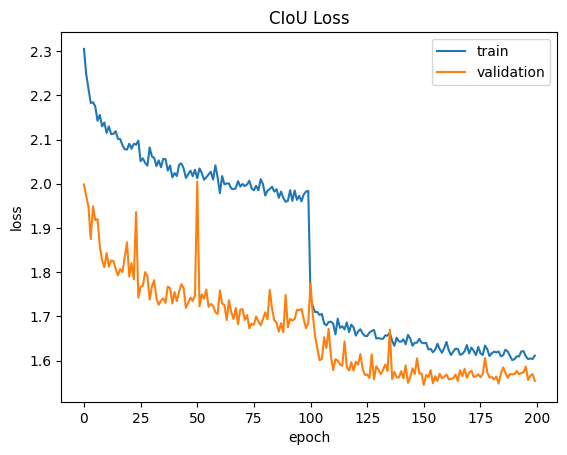

In [54]:
plt.plot(train_loss['ciou'])
plt.plot(test_loss['ciou'])
plt.title('CIoU Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig(save_pth + f'/ciou_loss_{version}.png', bbox_inches='tight')
plt.show()

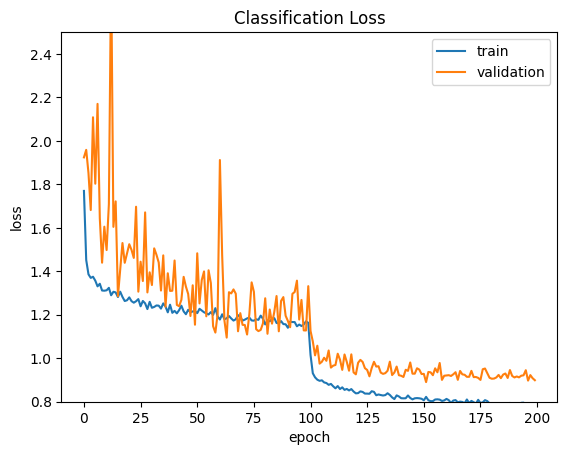

In [55]:
plt.plot(train_loss['cls'])
plt.plot(test_loss['cls'])
plt.ylim(0.8, 2.5)
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig(save_pth + f'/cls_loss_{version}.png', bbox_inches='tight')
plt.show()

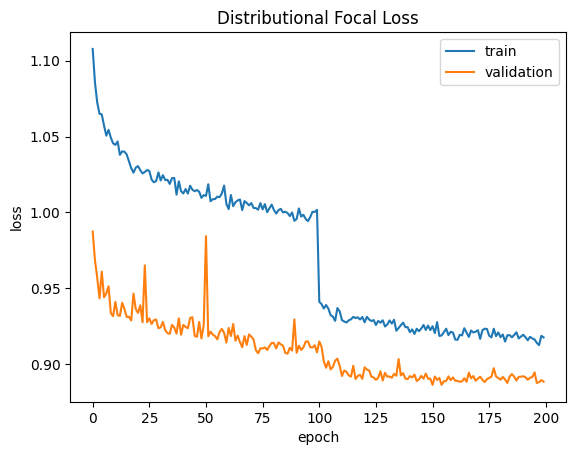

In [56]:
plt.plot(train_loss['dfl'])
plt.plot(test_loss['dfl'])
#plt.ylim(1., 1.4)
plt.title('Distributional Focal Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig(save_pth + f'/dfl_loss_{version}.png', bbox_inches='tight')
plt.show()

In [57]:
data = pd.read_csv(save_pth + f'/training_log_{version}.txt', sep=" ", header=0)
train_loss = dict()
test_loss = dict()
train_loss['ciou'] = list(data['train_ciou'])
train_loss['cls'] = list(data['train_cls'])
train_loss['dfl'] = list(data['train_dfl'])
test_loss['ciou'] = list(data['test_ciou'])
test_loss['cls'] = list(data['test_cls'])
test_loss['dfl'] = list(data['test_dfl'])

train_loss['total'] = [ciou+cls+dfl for ciou, cls, dfl in zip(train_loss['ciou'], train_loss['cls'], train_loss['dfl'])]
test_loss['total'] = [ciou+cls+dfl for ciou, cls, dfl in zip(test_loss['ciou'], test_loss['cls'], test_loss['dfl'])]

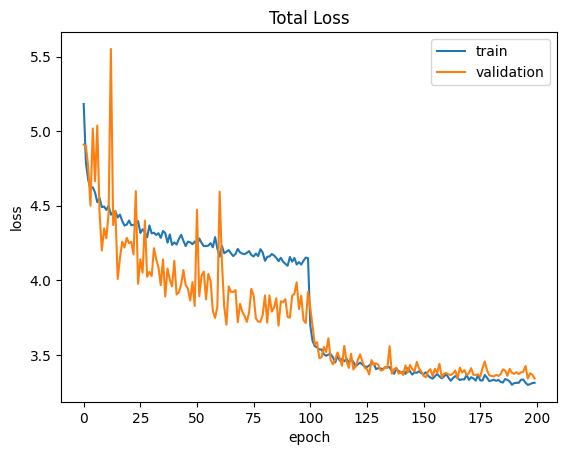

In [58]:
plt.plot(train_loss['total'])
plt.plot(test_loss['total'])
#plt.ylim(5., 7.5)
plt.title('Total Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig(save_pth + f'/total_loss_{version}.png', bbox_inches='tight')
plt.show()

In [39]:
image, bboxes, category_ids = next(iter(dataloader['val']))
trainer.model.eval()
pred = trainer.model(image.to(params['device']))
y = trainer.inference(pred)
print(pred[0].shape)
print(pred[1].shape)
print(pred[2].shape)
print(y.shape)

torch.Size([32, 18, 72, 40])
torch.Size([32, 18, 36, 20])
torch.Size([32, 18, 18, 10])
torch.Size([32, 6, 3780])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


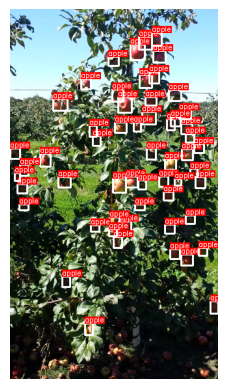

In [40]:
output = non_max_suppression(y, conf_thres=0.25, iou_thres=0.45, nc=len(classes)) # bbox xyxy, score, cls, nmask        
visualize_pred(image, output, classes)

## Import and evaluate trained model

In [63]:
# trained model
if str(params["device"]) == 'cuda':
    model = torch.load('checkpoint/minne_apple/model_152_newv10.pt').to(params["device"])
    #model = torch.load('checkpoint/mixed/model_189_v3.pt').to(params["device"])
else:
    model = torch.load('checkpoint/minne_apple/model_152_newv10.pt', map_location=torch.device('cpu')).to(params["device"])
    #model = torch.load('checkpoint/mixed/model_189_v3.pt').to(params["device"])

model.eval()
print(summary(model, torch.zeros((1, 3, 640, 640)).to(params["device"]), show_input=True))

--------------------------------------------------------------------------
       Layer (type)           Input Shape         Param #     Tr. Param #
       ConvModule-1      [1, 3, 640, 640]             464             464
       ConvModule-2     [1, 16, 320, 320]           4,672           4,672
              C2f-3     [1, 32, 160, 160]           5,040           5,040
       ConvModule-4     [1, 32, 160, 160]          18,560          18,560
              C2f-5       [1, 64, 80, 80]          31,168          31,168
       ConvModule-6       [1, 64, 80, 80]          36,992          36,992
              C2f-7       [1, 64, 40, 40]          31,168          31,168
       ConvModule-8       [1, 64, 40, 40]          36,992          36,992
              C2f-9       [1, 64, 20, 20]          19,808          19,808
            SPPF-10       [1, 64, 20, 20]          20,736          20,736
        Upsample-11       [1, 64, 20, 20]               0               0
             C2f-12      [1, 128, 40,

In [64]:
validator = v8DetectionValidator(device=params['device'],
                   nclasses=len(classes), 
                   classes=classes)
metrics_names = ['P','R','mAP50','mAP50-95']
metric_monitor = MetricMonitor()
stream = tqdm(dataloader['val'], ncols=170)
result = {}

inference = Inference(nclasses=len(classes), stride=torch.tensor([8,16,32]), reg_max=params["reg_max"], device=params['device'])
        
dataset_bboxes = torch.tensor([])
dataset_cls = torch.tensor([])
pred_output = []

with torch.no_grad():
    for i, (image, bboxes, category_ids) in enumerate(stream, start=1):
        
        dataset_bboxes = torch.cat([dataset_bboxes, bboxes.to('cpu')], dim=0)
        dataset_cls = torch.cat([dataset_cls, category_ids.to('cpu')], dim=0)
        
        batch = {'batch_idx' : image.to(params['device'], non_blocking=True), 
                 'cls' : category_ids.to(params['device'], non_blocking=True), 
                 'bboxes' : bboxes.to(params['device'], non_blocking=True)}
        
        preds = model(batch['batch_idx'])
        y = inference(preds)
        output = non_max_suppression(y, conf_thres=0.001, iou_thres=0.6, max_det=300, nc=len(classes), multi_label=False)

        pred_output.extend(output)
                
        stream.set_description("{metric_monitor}".format(metric_monitor=metric_monitor))
        
batch = {'cls' : dataset_cls.to(params['device'], non_blocking=True), 
         'bboxes' : dataset_bboxes.to(params['device'], non_blocking=True)}
result = validator(pred_output, batch, depth=True, plots=True)
print(result)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.25it/s]


{'seen': 331, 'instances': 12285, 'P': 0.7373563577442193, 'R': 0.6085470085470085, 'mAP50': 0.6858193803971356, 'mAP50-95': 0.3575454118847994}


In [33]:
transform = A.Compose([
        #A.SmallestMaxSize (max_size=params['img_size']),
        #A.PadIfNeeded(params['img_size'], params['img_size'], border_mode=0, value=(0.5, 0.5, 0.5)),
        A.Resize (params['img_size'], params['img_size']),
        ToTensorV2 (),
    ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image torch.Size([1, 3, 320, 320])
pred[0] torch.Size([1, 18, 40, 40])
pred[1] torch.Size([1, 18, 20, 20])
pred[2] torch.Size([1, 18, 10, 10])
y torch.Size([1, 6, 2100])


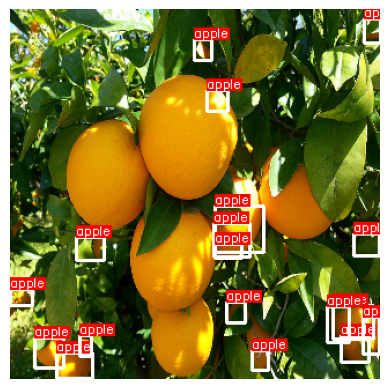

In [34]:
image = read_image('oranges/img1.jpg', ImageReadMode.RGB)

transformed = transform(image=np.array(image.permute(1,2,0), np.float32) / 255.)
image = transformed['image']
image = image.unsqueeze(0)

print(f'image {image.shape}')

pred = model(image.to(params['device']))
print(f'pred[0] {pred[0].shape}')
print(f'pred[1] {pred[1].shape}')
print(f'pred[2] {pred[2].shape}')

inference = Inference(nclasses=len(classes), reg_max=params['reg_max'], stride=torch.tensor([8,16,32]), device=params['device'])
y = inference(pred) # (bs, 4 + nclasses + depth, h*w)
print(f'y {y.shape}')

output = non_max_suppression(y, conf_thres=0.25, iou_thres=0.45, nc=len(classes)) # bbox xyxy, score, cls, nmask        
visualize_pred(image, output, classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image torch.Size([1, 3, 320, 320])
pred[0] torch.Size([1, 18, 40, 40])
pred[1] torch.Size([1, 18, 20, 20])
pred[2] torch.Size([1, 18, 10, 10])
y torch.Size([1, 6, 2100])


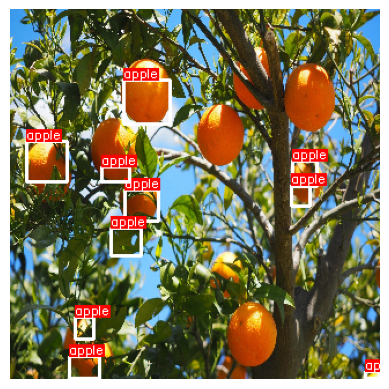

In [35]:
image = read_image('oranges/img2.jpeg', ImageReadMode.RGB)

transformed = transform(image=np.array(image.permute(1,2,0), np.float32) / 255.)
image = transformed['image']
image = image.unsqueeze(0)

print(f'image {image.shape}')

pred = model(image.to(params['device']))
print(f'pred[0] {pred[0].shape}')
print(f'pred[1] {pred[1].shape}')
print(f'pred[2] {pred[2].shape}')

inference = Inference(nclasses=len(classes), reg_max=params['reg_max'], stride=torch.tensor([8,16,32]), device=params['device'])
y = inference(pred) # (bs, 4 + nclasses + depth, h*w)
print(f'y {y.shape}')

output = non_max_suppression(y, conf_thres=0.25, iou_thres=0.45, nc=len(classes)) # bbox xyxy, score, cls, nmask        
visualize_pred(image, output, classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image torch.Size([1, 3, 320, 320])
pred[0] torch.Size([1, 18, 40, 40])
pred[1] torch.Size([1, 18, 20, 20])
pred[2] torch.Size([1, 18, 10, 10])
y torch.Size([1, 6, 2100])


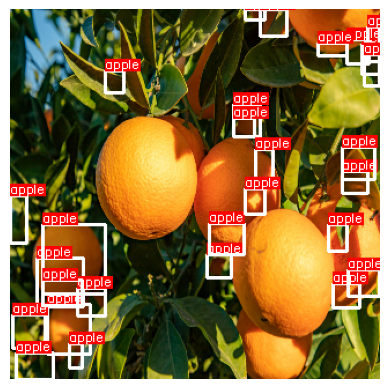

In [36]:
image = read_image('oranges/img3.jpeg', ImageReadMode.RGB)

transformed = transform(image=np.array(image.permute(1,2,0), np.float32) / 255.)
image = transformed['image']
image = image.unsqueeze(0)

print(f'image {image.shape}')

pred = model(image.to(params['device']))
print(f'pred[0] {pred[0].shape}')
print(f'pred[1] {pred[1].shape}')
print(f'pred[2] {pred[2].shape}')

inference = Inference(nclasses=len(classes), reg_max=params['reg_max'], stride=torch.tensor([8,16,32]), device=params['device'])
y = inference(pred) # (bs, 4 + nclasses + depth, h*w)
print(f'y {y.shape}')

output = non_max_suppression(y, conf_thres=0.25, iou_thres=0.45, nc=len(classes)) # bbox xyxy, score, cls, nmask        
visualize_pred(image, output, classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image torch.Size([1, 3, 320, 320])
pred[0] torch.Size([1, 18, 40, 40])
pred[1] torch.Size([1, 18, 20, 20])
pred[2] torch.Size([1, 18, 10, 10])
y torch.Size([1, 6, 2100])


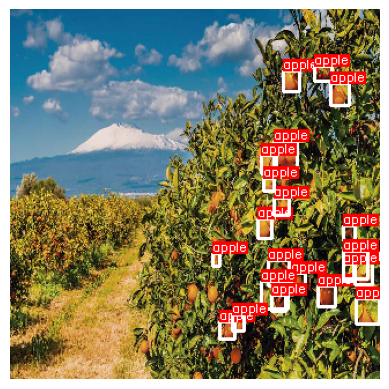

In [37]:
image = read_image('oranges/img4.jpg', ImageReadMode.RGB)

transformed = transform(image=np.array(image.permute(1,2,0), np.float32) / 255.)
image = transformed['image']
image = image.unsqueeze(0)

print(f'image {image.shape}')

pred = model(image.to(params['device']))
print(f'pred[0] {pred[0].shape}')
print(f'pred[1] {pred[1].shape}')
print(f'pred[2] {pred[2].shape}')

inference = Inference(nclasses=len(classes), reg_max=params['reg_max'], stride=torch.tensor([8,16,32]), device=params['device'])
y = inference(pred) # (bs, 4 + nclasses + depth, h*w)
print(f'y {y.shape}')

output = non_max_suppression(y, conf_thres=0.25, iou_thres=0.45, nc=len(classes)) # bbox xyxy, score, cls, nmask        
visualize_pred(image, output, classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image torch.Size([1, 3, 320, 320])
pred[0] torch.Size([1, 18, 40, 40])
pred[1] torch.Size([1, 18, 20, 20])
pred[2] torch.Size([1, 18, 10, 10])
y torch.Size([1, 6, 2100])


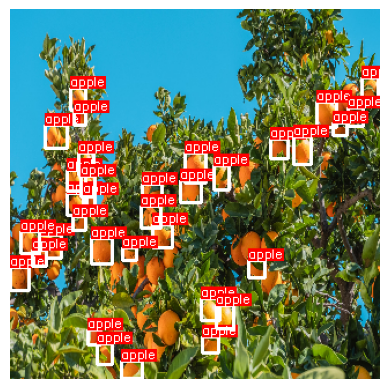

In [38]:
image = read_image('oranges/img5.jpg', ImageReadMode.RGB)

transformed = transform(image=np.array(image.permute(1,2,0), np.float32) / 255.)
image = transformed['image']
image = image.unsqueeze(0)

print(f'image {image.shape}')

pred = model(image.to(params['device']))
print(f'pred[0] {pred[0].shape}')
print(f'pred[1] {pred[1].shape}')
print(f'pred[2] {pred[2].shape}')

inference = Inference(nclasses=len(classes), reg_max=params['reg_max'], stride=torch.tensor([8,16,32]), device=params['device'])
y = inference(pred) # (bs, 4 + nclasses + depth, h*w)
print(f'y {y.shape}')

output = non_max_suppression(y, conf_thres=0.25, iou_thres=0.45, nc=len(classes)) # bbox xyxy, score, cls, nmask        
visualize_pred(image, output, classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 18, 72, 40])
torch.Size([32, 18, 36, 20])
torch.Size([32, 18, 18, 10])
torch.Size([32, 6, 3780])


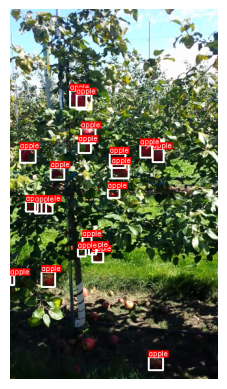

In [57]:
image, bboxes, category_ids = next(iter(dataloader['val']))
pred = model(image.to(params['device']))
print(pred[0].shape)
print(pred[1].shape)
print(pred[2].shape)

inference = Inference(nclasses=len(classes), reg_max=params['reg_max'], stride=torch.tensor([8,16,32]), device=params['device'])
y = inference(pred) # (bs, 4 + nclasses + depth, h*w)
print(y.shape)

output = non_max_suppression(y, conf_thres=0.25, iou_thres=0.45, nc=len(classes)) # bbox xyxy, score, cls, nmask        
visualize_pred(image, output, classes)